# Transformer를 이용한 한·영 번역 모델 생성 및 학습 예제
## : Mecab 형태소 분석기 및 SentencePiece의 성능 차이

<br><br>

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; Transformer를 이용하여 한국어-영어 번역 모델을 생성, 평가 하였다. 나아가, (1) Bahadanau Attention과 Transformer 모델의 번역 결과 비교와 (2) Mecab과 SentencePiece를 이용한 토큰화 기법에 따른 번역 결과를 비교 하였다. 데이터셋은 박정열(2017)이 제시한 한국어-영어 쌍 데이터셋을 이용하였으며, 데이터 분석을 통해 94,123개의 레코드로 구성 되어있으며, 15,155개의 중복데이터와 0개의 결측치가 있음을
확인 하였다. 또한, 언어별 4분위에 해당하는 문장의 토큰 개수를 확인한 결과, 한국어의 경우에는 약 31개의 토큰으로 이루어져있으며, 영어의 경우에는 약 50개의 토큰으로 이루어져있다. 이를 바탕으로 '중복 데이터 제거', '언어별 문장길이 제한', '정규식을 이용한 문장 전처리' 순으로 데이터 전처리를 수행하였다. 이후 Mecab과 SentencePiece를 이용하여 각각 토큰화를 진행하였다. 두 모델의 공정한 평가를 위해 하이퍼파라미터를 동일하게 설정 하였다. 2층의 인코딩, 디코딩 레이어를 이용하였으며, 임베딩 사이즈는 256, 멀티 헤드의 개수는 8개로 설정 하였다. 또한 학습 옵티마이저는 Adam을 사용하며 배치 사이즈는 64로 설정하고 학습 회수는 10회 진행 하였다. 세 모델의 번역 결과를 확인한 결과, 「오바마는 대통령이다.」라는 문장을 입력하였을 때, Bahdanau Attention의 경우 「obama is a member of us.」로 올바르지 않게 번역이 이루어졌다. Transformer의 경우 「obama is the president.」로 번역이 올바르게 이루어졌다. 또한, Mecab의 경우 「나는 고양이다.」 문장을 「I'm cat.」으로 비교적 올바르게 번역 하였다. 반대로 「일곱 명의 사망자가 발생했다.」의 문장의 경우에는 Transformer에서 「seven of the seven deaths.」와 「seven seven seven deaths seven deaths」로 번역 되어, Bahdanau Attention의 「seven people were killed.」가 비교적 잘 번역된 것이라 볼 수 있다. 「오바마는 대통령이다.」 문장에 대한 각 모델의 Attention을 시각화 하였을 때, Bahdanau Attention의 경우 「오바마」와 「president」의 연관성이 높지 않게 출력되었다. 하지만 Transformer의 경우에는 Mecab과 SentencePiece 모두 연관성이 높게 출력되어 모델이 이를 잘 학습 되어진 것을 확인할 수 있었다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 'aiffel_going_deeper' 저장소(Repository) 중 <a href="https://nbviewer.org/github/YAGI0423/aiffel_going_deeper/blob/main/going_deeper_08/GD08_v3_1.ipynb">[going_deeper 08]</a>에서는 Bahdanau Attention을 이용하여 한·영 번역 모델을 생성하고 이를 학습하는 예제를 진행하였습니다. 본 에제에서는 'going_deeper 08'의 연장선으로 트랜스포머 모델을 이용하여 동일한 데이터를 학습하고 앞선 Bahdanau Attention 모델의 번역 결과와 비교하여 성능 향상을 확인하고자 합니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 나아가, 한-영 데이터의 토큰화 시, Mecab 형태소 분석기와 SentencePiece 모델을 사용하여 토크나이저에 따른 번역 결과의 차이도 살펴 봅니다. 따라서, 바다나우 어텐션 모델의 번역 결과를 베이스라인으로 사용하고 Mecab과 SentencePiece의 번역 결과를 확인 하고자 합니다. [표 1]은 비교 모델을 제시한 것입니다. 다음은 예제의 진행 순서를 제시한 것입니다.
</span><br><br>

> _1. Bahdanau Attention 한-영 번역 모델_
>
> _2. 데이터 분석_
>
> _3. 데이터 전처리_
>
> _4. 모델 생성_
>
> _5. 모델 학습 및 평가_

<br>
    
|Index|Test Model|
|:--------:|:--------:|
|1|**Bahdanau Attention(Base Line)**|
|2|**Transformer(Mecab)**|
|3|**Transformer(SentencePiece)**|

[표 1] 한-영 번역 모델 제시

***

#### ___예제 진행에 앞서...___
***
+ 예제에서 사용하는 한국어 형태소 분석기 Mecab을 이용하기 위해 미리 설치 하여 줍니다.

> `$ sudo apt-get install g++ openjdk-8-jdk`   _#jdk 설치_
>
> `$ bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)`   #_curl을 이용한 Mecab 설치_
>
> `$ pip install konlpy`   #_konlpy 설치_
***

<br>

## 2. Bahdanau Attention 한-영 번역 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; <a href="https://nbviewer.org/github/YAGI0423/aiffel_going_deeper/blob/main/going_deeper_08/GD08_v3_1.ipynb">[going_deeper 08]</a>에서는 Bahdanau Attention 한-영 번역 모델을 생성하여 번역 결과를 확인 하였습니다. Attention은 seq2seq의 장기의존성 문제를 해결하기 위해 제시된 것으로 다양한 Attention이 존재 하며, 해당 에제에서는 Bahdanau Attention을 이용하였습니다. 모델의 번역 결과를 확인한 결과 번역이 올바르지 않게 이루어 졌지만, 주어나 명사에 대해 올바르게 번역 되었습니다. 다음은 going_deeper 08의 초록과 [표 2]는 바다나우 어텐션 모델의 한국어-영어 번역 결과를 제시한 것입니다.
</span>


><b>초록</b><br>
&nbsp; &nbsp; 바다나우 어텐션을 이용하여 한국어-영어 번역 모델을 생성하고 이를 평가 하였다. 데이터셋은 박정열(2017)이 제시한 한국어-영어 쌍으로 이루어진 데이터셋을 이용하였으며, 총94,123개의 레코드로 이루어져 있다. 분석 결과, 15,155개의 중복데이터가 존재하고 결측치는 존재하지 않았다. 한, 영 각 언어의 문장의 길이를 공백 기준으로 분석 하였다. 각 언어의 4분위에 해당하는 문장을 중심으로 한국어의 경우 약 31개의 토큰으로 이루어져 있으며, 영어의 경우 약 50개의 토큰으로 이루어져 있다. 데이터 전처리는 '중복 데이터 제거', '언어별 문장 길이 제한', '정규식을 이용한 문장 전처리', '문장 토큰화' 순으로 진행하여 최종 77,223개의 데이터를 모델 학습에 사용하였다. 모델의 경우 GRU 유닛 256개를 사용하였으며 임베딩 사이즈는 256으로 설정 하였다. 학습 옵티마이저는 Adam을 이용하고 배치 사이즈는 64, 학습 회수는 20회로 설정하였다. 최종 손실값은 1.545이다. 8개의 한국어 문장을 바다나우 어텐션 모델에 입력하여 번역 결과를 출력 한 결과, '오바마는 대통령이다.', '나는 고양이다' 등의 한국어 문장이 'obama is member of us.', 'i don't have a lot of the cat.'과 같이 문법에는 문제가 없지만, 입력 문장과 다른 내용의 번역문이 출력 되어, 번역이 올바르지 않게 이루어진 것을 확인 하였다. 이는 학습 데이터가 불충분 한 것이 원인으로 예상 되며, 그럼에도 불구하고 주어와 명사에 대해서 잘 예측하는 것을 확인 하였다.

<br>

|한국어 문장|영어 번역 결과|
|:--------:|:--------:|
|오바마는 대통령이다.|obama is a member of us.|
|시민들은 도시 속에 산다.|the city of the city of the city.|
|커피는 필요 없다.|the coffee is to be|
|일곱 명의 사망자가 발생했다.|seven people were killed.|
|나는 고양이다.|i don t have a lot of the cat.|
|아버지가 방에 들어가신다.|the father was a.|
|아버지 가방에 들어가신다.|the boy s father s|
|오늘은 크리스마스다.|today is a day|

[표 2] 바다나우 어텐션 모델의 한국어-영어 번역 결과

***

<br>

## 3. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Bahdanau Attention 모델에 사용한 데이터셋과 동일한 데이터셋을 사용합니다. 예제에서는 박정열(2017)이 제시한 한국어-영어 쌍의 데이터셋을 이용 합니다. 총 94,123개의 레코드로 이루어져 있으며, 15,155개의 중복 데이터가 존재하고 결측치는 없었습니다. 각 언어별 문장의 공백 기준 토큰의 개수를 확인 하였습니다. 한국어 데이터의 경우, 문장이 평균 약 14개의 토큰으로 이루어져 있고 4분위 문장의 경우 약 31개의 토큰으로 이루어져 있습니다. 영어 데이터의 경우, 문장이 평균 약 20개의 토큰으로 이루어져 있고 4분위 문장의 경우 약 50개의 토큰으로 이루어져 있습니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제 진행에 필요한 라이브러리를 호출 합니다.
***

In [1]:
import re   #정규식
import os   #디렉토리 관리
import io
import random   #학습 데이터 섞기
import tarfile #gz 압축 풀기


import numpy as np   #행렬 연산
import pandas as pd   #데이터프레임
import tensorflow as tf   #신경망


from konlpy.tag import Mecab   #형태소 분석
import sentencepiece as spm   #SentencePiece


from tqdm.notebook import tqdm   #학습과정 시각화
from tqdm import tqdm_notebook   #학습과정 시각화


import seaborn   #데이터 시각화
import matplotlib as mpl   #폰트
import matplotlib.pyplot as plt   #데이터 시각화
import matplotlib.font_manager as fm   #폰트


fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)
%config InlineBackend.figure_format = 'retina'

<br>

#### 데이터셋 압축 풀기
***
+ 데이터셋 압축파일 `korean-english-park.train.tar.gz`의 압축을 해제 합니다.
***

In [2]:
ap = tarfile.open("./dataset/korean-english-park.train.tar.gz")
ap.extractall("./dataset/")
ap.close()

#### 학습 데이터 출처
***
+ Jungyeul Park, korean-parallel-corpora(2017), https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1
***

<br>

#### 데이터셋 불러오기
***
+ 한국어 문장 데이터와 그 쌍에 해당하는 영어 문장 데이터를 불러옵니다.


+ 한국어 문장과 영어 문장을 쌍으로 하는 데이터 프레임을 생성 합니다.
***

In [3]:
path_to_ko = "./dataset/korean-english-park.train.ko"
path_to_en = "./dataset/korean-english-park.train.en"

with open(path_to_ko, "r") as f:
    kor_raw = f.read().splitlines()
    
with open(path_to_en, "r") as f:
    eng_raw = f.read().splitlines()
    
dataset = pd.DataFrame(zip(kor_raw, eng_raw), columns=["kor", "eng"])

<br>

#### 데이터셋 샘플 출력
***
데이터셋 샘플 5개 레코드를 출력 합니다.
***

In [4]:
dataset.sample(5)

,kor,eng
4651,(그 가게는 그런 상품은 취급하지 않는다.) 블름스베리 출판사도 이 강도 사건을 이...,Bloomsbury also used the robbery to remind the...
76625,The document deals with the use of American fo...,The Blue House announced yesterday that it had...
71810,오바마 당선인은 ABC 방송 ‘디스 위크(This Week)’에서 “팔레스타인 국민...,Rejecting criticism that he has been relativel...
957,맥도날드의 대변인 척 에벨링은 한숨을 쉬며 말한다.,Sighs McDonald's spokesman Chuck Ebeling:
11121,템펠호프 공항은 1948년 6월부터 1949년 5월까지 옛 소련이 베를린에 대한 봉...,The airport's backers have been appealing to B...


<br>

#### 데이터셋 기본 정보 확인
***
+ 총 94,123개 레코드가 존재하며 15,155개의 중복 데이터와 0개의 결측 데이터가 존재 합니다.
***

In [5]:
dataset.info()

dup = dataset.duplicated()
dup = dup.value_counts()[True]

print(f"Dupliacted Data Num: {dup:,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   kor     94123 non-null  object
 1   eng     94123 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB
Dupliacted Data Num: 15,155


<br>

#### 데이터 빈도 시각화 및 출력 함수 생성
***
+ 데이터 빈도 시각화 및 출력하는 함수를 생성 합니다.


+ 데이터 토큰화 이후, 문장의 길이와 단어 사용 빈도를 확인하기 위해 사용 합니다.
***

In [6]:
#데이터 길이 시각화 함수=========================
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)
#End===========================================

<br>

#### 데이터 문장 길이 확인
***
+ 한국어 데이터의 경우, 문장이 평균 약 14개의 단어로 이루어져 있으며, 4분위의 경우 약 31개의 단어로 이루어져 있습니다.


+ 영어 데이터의 경우, 문장이 평균 약 20개의 단어로 이루어져 있으며, 4분위의 경우 약 50개의 단어로 이루어져 있습니다.

***

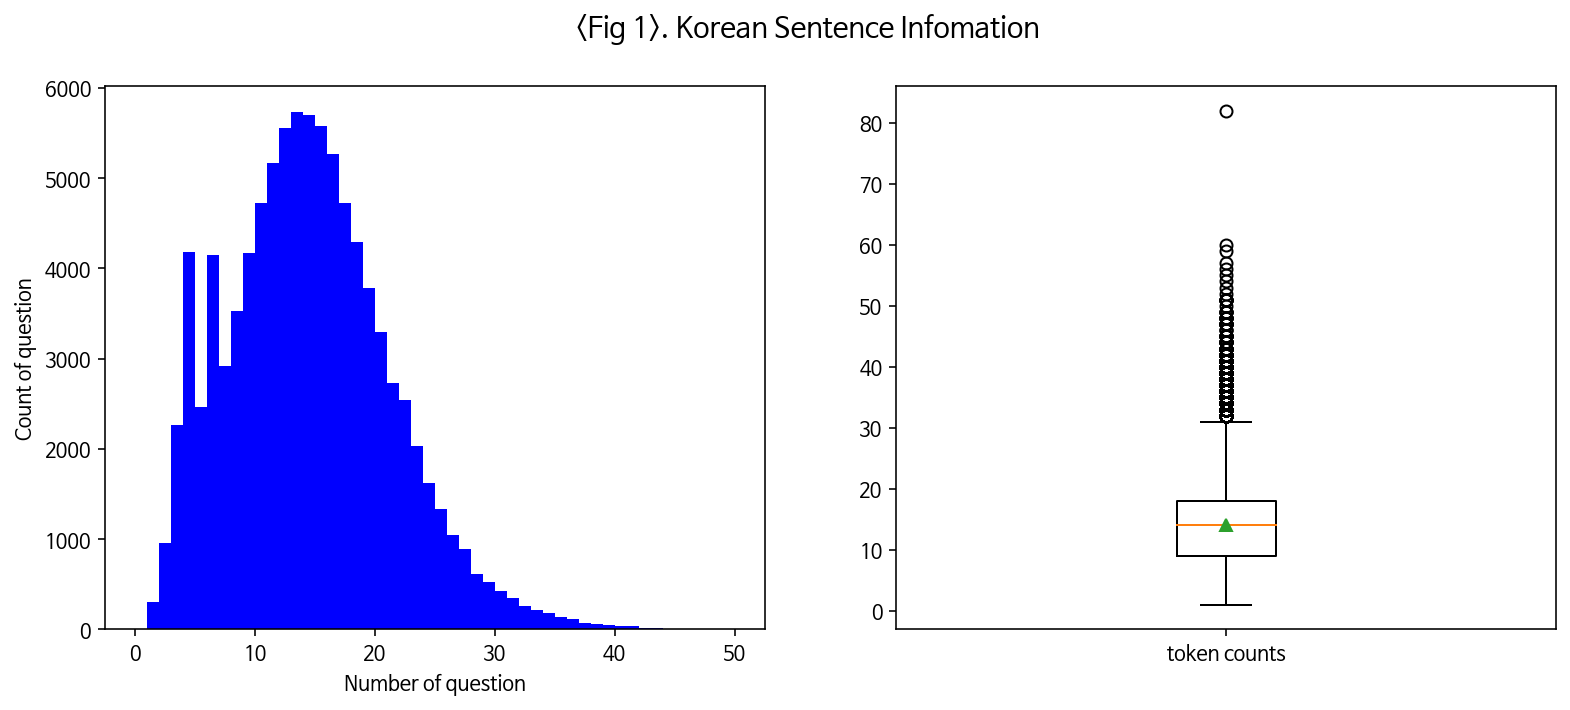

=========================================< Sentence Info >==========================================
길이 최대:      82
길이 최소:       1
길이 평균:     14.047
길이 표준편차:   6.813

 25/100분위:    9.000
 50/100분위:   14.000
 75/100분위:   18.000
 MAX/100분위:  31.500
 IQR:   9.000


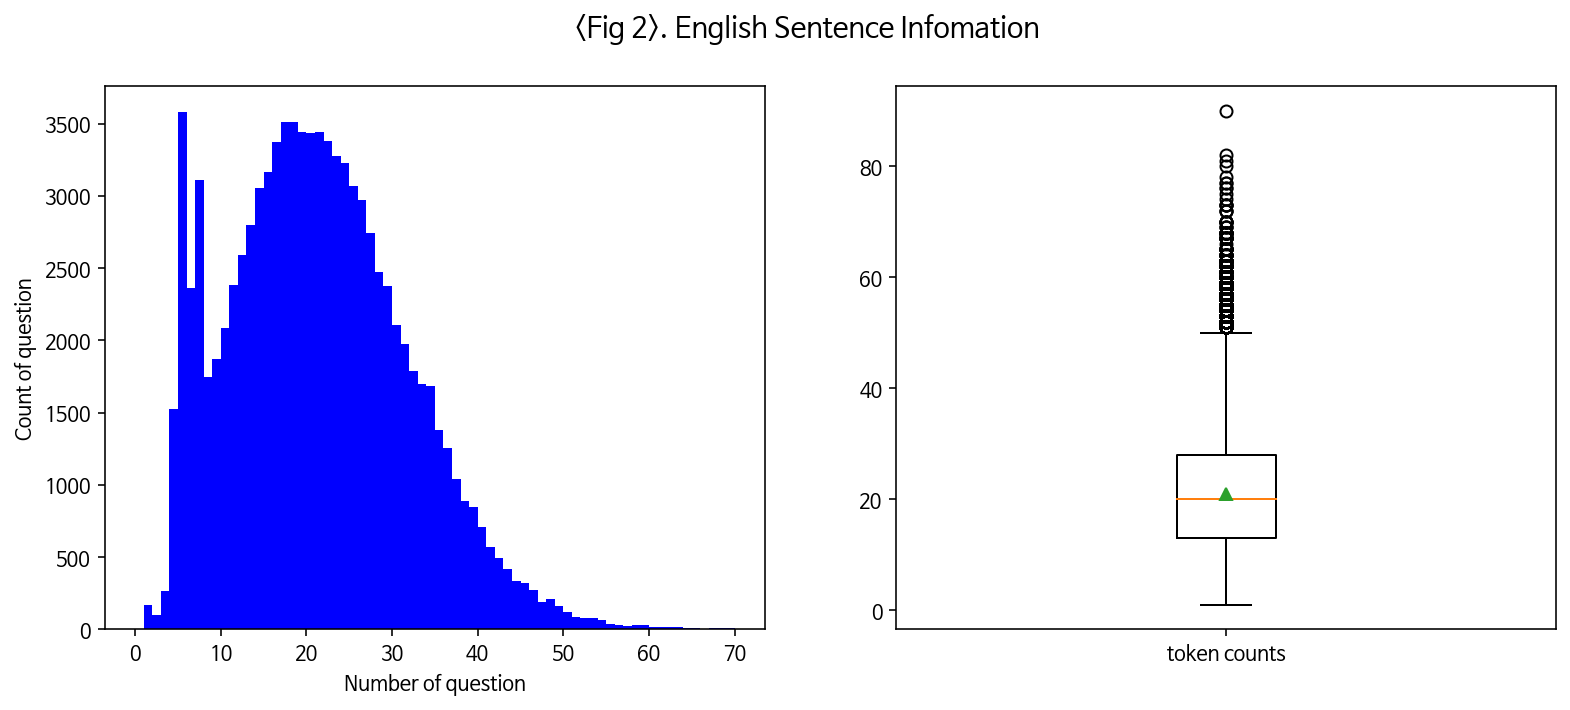

=========================================< Sentence Info >==========================================
길이 최대:      90
길이 최소:       1
길이 평균:     20.897
길이 표준편차:  10.471

 25/100분위:   13.000
 50/100분위:   20.000
 75/100분위:   28.000
 MAX/100분위:  50.500
 IQR:  15.000


In [7]:
kor_counts = [len(text.split()) for text in dataset["kor"]]
eng_counts = [len(text.split()) for text in dataset["eng"]]

show_sentence_length(kor_counts, "<Fig 1>. Korean Sentence Infomation", [0, 50])
show_sentence_length(eng_counts, "<Fig 2>. English Sentence Infomation", [0, 70])

<br>

## 4. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 수행한 데이터 분석을 바탕으로 전처리를 수행 합니다. 전처리 수행 과정은 '중복 데이터 제거', '언어별 문장 길이 제한', '정규식을 이용한 문장 전처리' 순으로 진행하였습니다. 우선, 15,155개의 중복 데이터를 제거하고 한국어의 경우 31개 초과 토큰으로 구성된 문장과 영어의 경우 50개 초과 토큰으로 구성된 문장을 제외하여 줍니다. 정규식을 이용하여 특수문자 제거 및 공백 추가를 시행 합니다.
</span>

***

#### 중복 데이터 제거
***
+ 중복 데이터를 제거하여 총 78,968개의 데이터를 획득 합니다.
***

In [8]:
dataset.drop_duplicates(inplace=True)
print(f"Data Num: {len(dataset):,}")

Data Num: 78,968


<br>

#### 문장 길이 기준 데이터 필터링
***
+ 문장 길이를 설정하고 해당 길이 이상의 문장은 제외 하여 줍니다.


+ 한국어의 경우 31개 초과의 단어로 이루어진 문장을, 영어의 경우 50개 초과의 단어로 이루어진 문장을 제외 합니다.
***

In [9]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(dataset, "kor", 31)
dataset = filt_sentence_length(dataset, "eng", 50)

<br>

#### 정규식을 이용한 문장 전처리
***
+ 정규식을 이용하여 특수문자 제거 및 공백 추가 등의 작업을 수행 합니다.


+ 영어의 경우 디코더에 입력되므로 <sos>, <eos> 토큰을 문장의 앞, 뒤에 추가 하여 줍니다.
    
<br>

> + _모든 입력을 소문자로 변환_
>
>
> + _알파벳, 문장부호, 한글만 남기고 모두 제거_
>
>
> + _문장부호 양옆에 공백을 추가_
>
>
> + _문장 앞뒤의 불필요한 공백을 제거_
***

In [10]:
#전처리 함수===========================
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
#End===================================


dataset["kor"] = dataset["kor"].apply(preprocess_sentence)
dataset["eng"] = dataset["eng"].apply(preprocess_sentence)

dataset.sample(5)

,kor,eng
44584,홀츠맨은 인터뷰를 통해 일렉트라는 비전을 갖고 있기 때문에 중요한 것 이라고 말했다 .,"elektra mattered , holzman says in a phone int..."
38526,헨슬리 하사와 산도발 병장 모두 알래스카주 포트 리차드슨의 미 육군 1 대대 5 0...,both are assigned to the u . s . army s 1 st b...
84495,석유생산국의 1 4 개 회원국은 이달 말 회담을 갖게 됩니다 .,1 4 members of the oil producing nations will ...
47233,지난달 2 1 일자 성명에서 알 말리키 총리는 의료 진단을 통해 그 여성이 성폭행을...,"in a statement february 2 1 , al maliki said m..."
42003,사건은 국제 안보 박람회 행사가 열리고 있는 울러스에서 교통이 혼잡한 러시아 워에 ...,the rush hour explosion went off in a busy sho...


<br>

## 5. 데이터 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 'Attention 모델'과 'Transformer 모델'의 번역 결과와 함께 'Mecab'과 'SentencePiece' 토크나이저에 따른 번역 결과도 확인하고자 합니다. 따라서, 전처리를 시행한 데이터를 이용하여 각기의 토큰화를 수행할 것입니다. Mecab은 한국어 형태소 분석기로 한국어는 Mecab을 이용하여 형태소 기준으로 토큰화를 시행하고 영어는 공백을 기준으로 토큰화 합니다. SentencePiece은 문자의 빈도를 바탕으로 토큰화를 실시하기 때문에 다양한 언어에 적용할 수 있다는 장점이 있습니다. 따라서, 한국어와 영어 데이터 모두 SentencePiece를 이용하여 토큰화를 시행 할 것입니다.
</span>

***

### 5.1. Mecab을 이용한 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Mecab을 이용한 토큰화는 한국어의 경우 Mecab 형태소 분석기를 이용하여 토큰화를 진행하고 영어의 경우 공백을 기준으로 토큰화를 진행합니다. 단어사전의 크기는 한국어의 경우 4분위에 해당하는 토큰이 18회 사용되는 것을 근거로 18회 이하로 사용된 토큰 42,627개를 이용 합니다. 영어의 경우 4분위에 해당하는 토큰이 21회 사용된 것을 근거로 21회 이하로 사용된 토큰 37,591개를 이용 합니다. 최종 77,223개의 한-영 데이터 쌍을 획득 합니다.
</span>

***

#### 디코더 입력 데이터 &lt;SOS>, &lt;EOS> 토큰 추가 하기
***
+ 디코더에 입력할 영어 데이터 문장 앞, 뒤에 &lt;SOS> 및 &lt;EOS> 토큰을 추가하여 줍니다.
***

In [11]:
#sos 및 eos 토큰 추가==================
def append_os_token(sentence):
    sentence = "<sos> " + sentence + " <eos>"
    return sentence
#End===================================

mecab_dataset = dataset.copy()
mecab_dataset["eng"] = dataset["eng"].apply(append_os_token)
mecab_dataset.sample(5)

,kor,eng
39218,폴 l . 프리드먼 미국 지방 법원 판사는 그러나 그의 요청을 기각했다 .,<sos> u . s . district judge paul l . friedman...
54336,과학기술에 진보한 집단이 온라인 검색을 하는 동안 이를 거의 경험하지 못한 다른 집...,<sos> members of the technologically advanced ...
2290,"북한의 조국 평화통일 위원회 사무국은 mgm 히트작은 미국이 변칙 , 타락 , 폭력...",<sos> the mgm hit proves that the united state...
79604,저명한 민주화 운동 지도자인 민꼬나잉 min ko naing 을 포함한 활동가들은 ...,<sos> the activists including prominent pro de...
57319,이번 에 개발된 인공심장은 수백명의 생명을 구할 수 있으며 심박동수와 혈류를 조절하...,<sos> the device could save millions of lives ...


<br>

#### Mecab을 이용한 문장 토큰화 함수 생성
***
+ Mecab 형태소 분석기를 이용하여 토큰화를 수행하는 함수를 생성 합니다.


+ seq2seq 모델에 입력할 한국어 데이터와 영어 데이터를 토큰화 합니다.


+ 한국어의 경우 인코더에 입력되며, Mecab을 이용하여 형태소 단위로 토큰화를 진행 합니다.


+ 영어의 경우 디코더에 입력되며, 공백을 단위로 토큰화를 진행 합니다.
***

In [12]:
def mecab_tokenize(corpus, vocab_size, maxlen, encoder_TF=True):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        oov_token="<UNK>",
        num_words=vocab_size
    )
    corpus_input = corpus
    
    if encoder_TF:   #encoder data는 '한국어'이므로 mecab 형태소 분석
        m = Mecab()
    
        corpus_input = []
        for sentence in corpus:
            corpus_input.append(m.morphs(sentence))
    
    tokenizer.fit_on_texts(corpus_input)
    
    if vocab_size is not None:
        words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]
    
    tensor = tokenizer.texts_to_sequences(corpus_input)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post',
        maxlen=maxlen
    )
    return tensor, tokenizer

<br>

#### Mecab을 이용한 문장 토큰화 진행
***
+ 모델에 입력하기 위한 언어별 데이터를 토큰화 합니다.


+ 해당 토큰화는 좀 더 구체적인 분석을 위해 진행하는 것이므로, 모든 단어를 사용하고 패딩의 경우 최대 길이로 설정 합니다.


+ 한국어의 경우 49,702개의 토큰이, 영어의 경우 43,830개의 토큰이 생성 되었습니다.

***

In [13]:
mecab_enc_tensor, mecab_enc_tokenizer = mecab_tokenize(mecab_dataset["kor"], None, None, encoder_TF=True)
mecab_dec_tensor, mecab_dec_tokenizer = mecab_tokenize(mecab_dataset["eng"], None, None, encoder_TF=False)

print("Korean Vocab Size:", f"{len(mecab_enc_tokenizer.word_index):,}")
print("English Vocab Size:", f"{len(mecab_dec_tokenizer.word_index):,}")

Korean Vocab Size: 49,702
English Vocab Size: 43,830


<br>

#### 토큰별 사용 빈도 확인
***
+ 추후 단어사전 크기를 설정하기 위해, 한국어와 영어 토큰별 사용 빈도를 확인 합니다.


+ 한국어의 경우 토큰은 평균 약 46회 사용 되었고 4분위의 토큰은 약 18회 사용 되었습니다.


+ 영어의 경우 토큰은 평균 약 48회 사용 되었고 4분위의 토큰은 약 21회 사용 되었습니다.
***

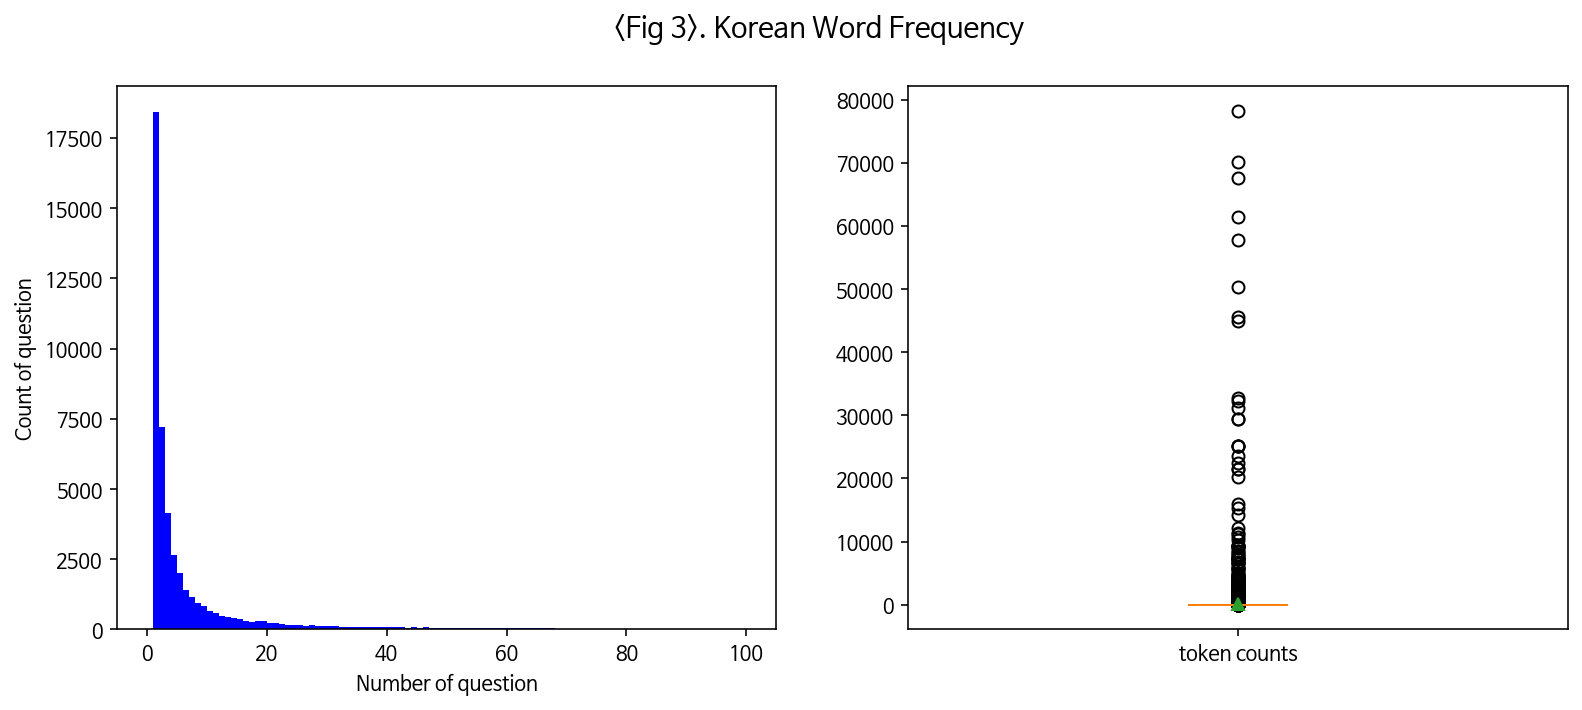

=========================================< Sentence Info >==========================================
길이 최대:    78266
길이 최소:       1
길이 평균:     46.053
길이 표준편차: 920.852

 25/100분위:    1.000
 50/100분위:    2.000
 75/100분위:    8.000
 MAX/100분위:  18.500
 IQR:   7.000


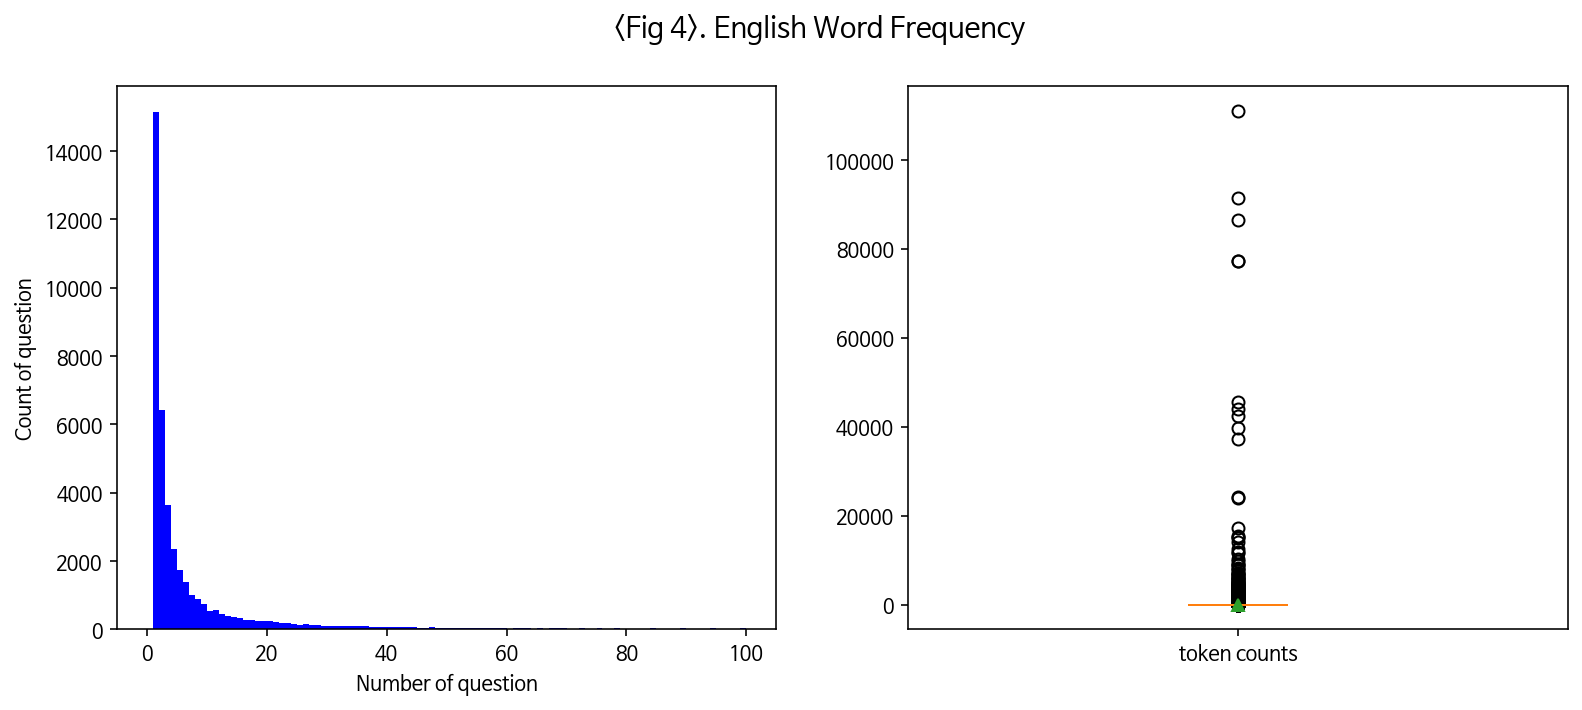

=========================================< Sentence Info >==========================================
길이 최대:    111106
길이 최소:       1
길이 평균:     48.212
길이 표준편차: 1107.312

 25/100분위:    1.000
 50/100분위:    3.000
 75/100분위:    9.000
 MAX/100분위:  21.000
 IQR:   8.000


In [14]:
enc_freq = [value for value in mecab_enc_tokenizer.word_counts.values()]
dec_freq = [value for value in mecab_dec_tokenizer.word_counts.values()]

show_sentence_length(enc_freq, "<Fig 3>. Korean Word Frequency", [0, 100])
show_sentence_length(dec_freq, "<Fig 4>. English Word Frequency", [0, 100])

<br>

#### 토큰별 사용 빈도 확인
***
+ 사용빈도 4분위에 해당하는 토큰의 수를 확인 합니다.


+ 한국어의 경우 18회 이하로 사용된 토큰은 총 43,271개 입니다.


+ 영어어의 경우 21회 이하로 사용된 토큰은 총 38,050개 입니다.
***

In [15]:
def wordNumByFreq(tokenizer, freq_num):
    sorted_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])
    for idx, (_, freq) in enumerate(sorted_freq):
        if freq > freq_num: break;
    return idx


print(f"Korean Words Used Under {18}: {wordNumByFreq(mecab_enc_tokenizer, 18):,}")
print(f"English Words Used Under {21}: {wordNumByFreq(mecab_dec_tokenizer, 21):,}")

Korean Words Used Under 18: 42,516
English Words Used Under 21: 37,506


<br>

#### 최종 토큰화 진행
***
+ 앞서 확인한 문장의 길이, 토큰 사용 빈도를 바탕으로, 토큰화를 진행 합니다.


+ 단어 사전의 크기는 한국어의 경우 42,516개로 설정 하고, 영어의 경우 37,506개로 설정 합니다.


+ 최종 데이터는 총 77,223개 입니다.
***

In [16]:
mecab_enc_tensor, mecab_enc_tokenizer = mecab_tokenize(mecab_dataset["kor"], 42516, None, encoder_TF=True)
mecab_dec_tensor, mecab_dec_tokenizer = mecab_tokenize(mecab_dataset["eng"], 37506, None, encoder_TF=False)

print(f"Dataset num: {len(mecab_enc_tensor):,}")

Dataset num: 77,223


<br>

### 5.2.SentencePiece를 이용한 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; SentencePiece를 이용한 토큰화는 Mecab과 다르게 한국어와 영어 모두 Sentence 모델을 이용합니다. 언어별 토크나이저를 생성하고 이를 바탕으로 토큰화를 실시 합니다. 한국어의 경우 32,000개의 토큰을 사용하고 영어의 경우 24,938개의 토큰을 사용 합니다.
</span>

***

#### SentencePiece를 이용한 문장 토큰화 함수 생성
***
+ SentencePiece를 이용하여 한국어, 영어 데이터 토큰화 함수를 생성 합니다.
***

In [17]:
#Get tokenizer==================================
def generate_tokenizer(corpus, model_type='unigram', vocab_size=32000, lang="ko"): 
    input_file = f'./dataset/{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))
        
    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)
    
    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    
    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s '
    input_argument += '--model_prefix=%s --vocab_size=%s --character_coverage=%s --model_type=%s'
    
    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, character_coverage, model_type)
                      
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')
    
    return tokenizer
#End============================================


#Get tokenizer & tensor=========================
def sentence_tokenize(data, vocab_size, langue):
    tokenizer = generate_tokenizer(data, 'unigram', vocab_size, langue)
    if langue == "en":
        tokenizer.set_encode_extra_options("bos:eos")
    
    tensor = data.apply(tokenizer.EncodeAsIds).tolist()
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post',
        maxlen=None
    )
    return tensor, tokenizer
#End============================================

<br>

#### SentencePiece를 이용한 문장 토큰화 시행
***
+ 앞서 생성한 함수를 이용하여 문장 토큰화를 시행 합니다.
***

In [18]:
sen_enc_tensor, sen_enc_tokenizer = sentence_tokenize(dataset["kor"], 32000, "ko")
sen_dec_tensor, sen_dec_tokenizer  = sentence_tokenize(dataset["eng"], 24938, "en")

<br>

## 6. Transformer 모델 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 트랜스포머 모델은 크게 인코더 부분과 디코더 부분으로 이루어져 있습니다. 모델의 목표는 'seq2seq'의 '시계열 데이터를 입력하여 시계열 데이터를 얻는 것'과 동일합니다. 기본적인 아이디어는 'Attention'만을 이용하여 'seq2seq'를 수행 하는 것입니다. 또한, 기존의 'Attention'은 RNN을 이용하여 데이터의 입력이 '순차적'으로 수행되었지만, 트랜스포머의 데이터 입력은 '동시에' 혹은 '병렬적'으로 수행된다는 특징이 있습니다. Transformer의 작동 방식과 각 레이어의 역할에 대한 설명은 'aiffel_exploration' 저장소((Repository)의 <a href="https://nbviewer.org/github/YAGI0423/aiffel_exploration/blob/master/exploration_15/EX15_v3_1.ipynb">[Exploration 15]</a>에서 자세히 다루고 있습니다. 
</span>

***

#### Positional 인코딩 레이어 및 멀티 헤드 어텐션 레이어 함수 정의
***
+ Positional 인코딩 레이어 및 멀티 헤드 어텐션 레이어 함수를 정의 합니다.

In [19]:
#Positional Encoding==================================================
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table
#End==================================================================


#MultiHeadAttention====================================================
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights
#End==================================================================

    
#Position-wise Feed-Forward Network===================================
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out
#End==================================================================


#Mask 레이어==========================================================
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask
#End==================================================================

<br>

#### 인코더 레이어 및 디코더 레이어 함수 정의
***
+ 인코더 레이어 및 디코더 레이어 함수를 정의 생성합니다.

In [20]:
#Encoder 레이어=======================================================
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn
#End==================================================================


#Decoder 레이어=======================================================
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
       
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
#End==================================================================

<br>

#### 인코더 및 디코더 함수 정의
***
+ 인코더 및 디코더 함수를 정의 생성합니다.

In [21]:
#Encoder==============================================================
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
#End==================================================================


#Decoder==============================================================
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
#End==================================================================

<br>

#### 트랜스포머 함수 정의
***
+ 트랜스포머 생성 함수를 정의합니다.

In [22]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

            
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

<br>

## 7. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Mecab 데이터와 SentencePiece 데이터를 학습할 각 모델을 생성 합니다. 두 모델은 공정한 평가를 위해 동일한 하이퍼파라미터로 설정 합니다. 트랜스포머 모델은 두 층의 인코딩, 디코딩 레이어를 사용 합니다. 임베딩 사이즈는 256이며 멀티 헤드의 개수는 8개로 설정 하였습니다. 또한 학습 옵티마이저는 Adam을 사용하며 배치 사이즈는 64로 설정하고 5epoch 마다 한국어 예제 문장을 모델에 입력하여 번역 결과를 출력하고 최종 epoch에서는 Attention Map을 시각화 합니다. [표 3]은 테스트 시 입력되는 한국어 문장을 제시한 것입니다.
</span>

|Index|입력 한국어 문장|
|:--------:|:--------:|
|1|오바마는 대통령이다.|
|2|시민들은 도시 속에 산다.|
|3|커피는 필요 없다.|
|4|일곱 명의 사망자가 발생했다.|
|5|나는 고양이다.|
|6|아버지가 방에 들어가신다.|
|7|아버지 가방에 들어가신다.|
|8|오늘은 크리스마스다.|

[표 3] 테스트 한국어 문장

***

#### 학습 옵티마이저 설정
***
+ 학습률의 경우 고정된 값을 이용하지 않고 `LearningRateScheduler`를 이용하여, 높은 학습률로부터 점차 낮추는 방식을 사용 합니다.


+ 옵티마이저는 Adam을 이용합니다.
***

In [23]:
#LearningRateScheduler=====================
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
#End=======================================


#손실 함수=================================  
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)    
#End=======================================

    
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

<br>

#### 학습 함수 정의
***
+ 'GradientTape'를 이용하여 학습 함수를 정의 합니다.
***

In [24]:
# Train Step 함수======================================

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns
#End===================================================

<br>

#### 학습 과정 출력 함수 정의
***
+ 학습 과정 중, 모델에 한국어 문장을 입력하여 변역 결과를 출력 합니다.
***

In [25]:
# Attention 시각화 함수================================
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        seaborn.heatmap(
            data, 
            square=True,
            vmin=0.0, vmax=1.0, 
            cbar=False, ax=ax,
            xticklabels=x, yticklabels=y
        )
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print(f"< Encoder Layer(=Self Attention) {layer + 1} >".center(100, "="))
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        print("=" * 100, end="\n\n\n")
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print(f"< Decoder Self Layer {layer + 1} >".center(100, "="))
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()
        print("=" * 100, end="\n\n\n")

        print(f"< Decoder Layer(Context Vector By Decoder Input) {layer + 1} >".center(100, "="))
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()
        print("=" * 100, end="\n\n\n")
#End===================================================


#번역 함수=============================================
def evaluate(
    sentence,
    model,
    src_tokenizer, tgt_tokenizer,
    enc_maxlen, dec_maxlen,
    tokenizer_type
):
    #tokenizer_type = True: Mecab, False: SentencePiece
    
    def idx_to_text(idx, tokenizer_type):
        if tokenizer_type:
            return tgt_tokenizer.sequences_to_texts([idx])
        else:
            return tgt_tokenizer.decode_ids(idx)
        
    sentence = preprocess_sentence(sentence)
    
    if tokenizer_type:
        m = Mecab()
        sentence = m.morphs(sentence)
        pieces = sentence
        _input = src_tokenizer.texts_to_sequences([sentence])
        
        sos_idx = tgt_tokenizer.word_index['<sos>']
        eos_idx = tgt_tokenizer.word_index['<eos>']
    else:
        pieces = src_tokenizer.encode_as_pieces(sentence)
        _input = [src_tokenizer.encode_as_ids(sentence)]
        
        sos_idx = tgt_tokenizer.bos_id()
        eos_idx = tgt_tokenizer.eos_id()
        
    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=enc_maxlen,
        padding='post'
    )
    
    ids = []
    output = tf.expand_dims([sos_idx], 0)
    
    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()
        
        if predicted_id == eos_idx:
            result = idx_to_text(ids, tokenizer_type)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = idx_to_text(ids, tokenizer_type)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns
#End===================================================


#번역 함수2============================================
def translate(
    sentence,
    model,
    src_tokenizer, tgt_tokenizer,
    enc_maxlen, dec_maxlen,
    plot_attention=False,
    tokenizer_type=True
):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(
        sentence,
        model,
        src_tokenizer, tgt_tokenizer,
        enc_maxlen, dec_maxlen,
        tokenizer_type=tokenizer_type
    )
    if tokenizer_type:
        result = " ".join(result) 
    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
    else:
        print("Korean Sentence:".rjust(18), sentence)
        print("English Sentence:".rjust(18), result, end="\n\n")
#End===================================================

<br>

#### 최종 학습 함수 정의
***
+ 배치 사이즈는 64로 설정하고 학습 회수는 10회로 설정합니다.


+ 5 epoch 마다 한국어 예제 문장을 입력하여 번역 결과를 출력하고 마지막 epoch에서는 Attention Map을 시각화 합니다.
***

In [26]:
BATCH_SIZE = 64
EPOCHS = 10

examples = [
    "오바마는 대통령이다.", "시민들은 도시 속에 산다.",
    "커피는 필요 없다.", "일곱 명의 사망자가 발생했다.",
    "나는 고양이다.", "아버지가 방에 들어가신다.",
    "아버지 가방에 들어가신다.", "오늘은 크리스마스다."
]

def fit(enc_train, dec_train, enc_tokenizer, dec_tokenizer, tokenizer_type=True):
    enc_maxlen, dec_maxlen = enc_train.shape[-1], dec_train.shape[-1]
    
    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm_notebook(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(
                enc_train[idx:idx+BATCH_SIZE],
                dec_train[idx:idx+BATCH_SIZE],
                transformer,
                optimizer
            )

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.3f' % (total_loss.numpy() / (batch + 1)))
        
        if (epoch+1) % 5 == 0:
            print(f"< EPOCH {epoch} >".center(100, "=")) 
            for example in examples: 
                translate(
                    example,
                    transformer,
                    enc_tokenizer, dec_tokenizer,
                    enc_maxlen, dec_maxlen,
                    tokenizer_type=tokenizer_type,
                    plot_attention=False
                )
            print("=" * 100, end="\n\n\n")
        
        if (epoch+1) == EPOCHS:
            translate(
                examples[0],
                transformer,
                enc_tokenizer, dec_tokenizer,
                enc_maxlen, dec_maxlen,
                tokenizer_type=tokenizer_type,
                plot_attention=True
            )


<br>

### 7.1. Mecab 기반 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 한국어 문장의 경우 Mecab을 이용하여 형태소 기준으로 토큰화를 수행하고 영어의 경우 공백을 기준으로 토큰화를 수행하였습니다. 그 결과 한국어의 단어사전 크기는 42,516개 이고 영어의 경우 37,506개 입니다. 따라서 Mecab 기반 모델의 단어 사이즈는 이를 기반으로 설정 하고 그외의 하이퍼파라미터는 동일하게 설정 합니다. 최종 손실값은 2.350 입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 8개의 한국어 문장을 입력하여 모델이 출력한 번역 문장을 확인한 결과, '오바마는 대통령이다.', '시민들은 도시 속에산다' 등의 한국어 문장을 'obama is the president.', 'citizens are generally much in cities.'로 올바르게 번역하였습니다. 그러나, 'seven of the seven deaths.', 'today's christmas is today.'와 같이 의미는 이해할 수 있지만 문법이 잘 못된 번역이 이루어진 경우도 존재 합니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 인코더와 디코더의 셀프 어텐션과 인코더-디코더 어텐션을 시각화 하였습니다. 인코더-디코더 어텐션 시각화 결과를 확인하였을 때, '오바마'와 'obama' 그리고 '오바마'와 'president'의 연관도가 높음을 알 수 있습니다. 이는 Transformer 모델이 'obama'가 'president'인 것을 올바르게 학습한 것이라 할 수 있습니다.
</span>

***

#### 모델 생성 및 학습
***
+ Mecab 데이터를 학습할 모델을 생성하고 학습 합니다.


+ 인코더 단어사전의 크기는 42,516이며, 디코더 단어사전의 크기는 37,506으로 설정 합니다.
***

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

============================================< EPOCH 4 >=============================================
  Korean Sentence: 오바마는 대통령이다.
 English Sentence: obama s president is a kind of american .

  Korean Sentence: 시민들은 도시 속에 산다.
 English Sentence: citizens are citizens of the cities of the cities .

  Korean Sentence: 커피는 필요 없다.
 English Sentence: coffee is not a coffee coffee

  Korean Sentence: 일곱 명의 사망자가 발생했다.
 English Sentence: seven people were killed .

  Korean Sentence: 나는 고양이다.
 English Sentence: i m cat .

  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: father father and father of the father of the room , which was sent to the room to the room .

  Korean Sentence: 아버지 가방에 들어가신다.
 English Sentence: the bag bag to bag , the bag .

  Korean Sentence: 오늘은 크리스마스다.
 English Sentence: this christmas christmas shoppers are christmas .





  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

============================================< EPOCH 9 >=============================================
  Korean Sentence: 오바마는 대통령이다.
 English Sentence: obama is the president .

  Korean Sentence: 시민들은 도시 속에 산다.
 English Sentence: citizens are generally much in cities .

  Korean Sentence: 커피는 필요 없다.
 English Sentence: why don t take advantage of the coffee .

  Korean Sentence: 일곱 명의 사망자가 발생했다.
 English Sentence: seven of the seven deaths .

  Korean Sentence: 나는 고양이다.
 English Sentence: i m cat .

  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: father and brother husband , like he was taken to a room .

  Korean Sentence: 아버지 가방에 들어가신다.
 English Sentence: then bag contained bag bag , and bag .

  Korean Sentence: 오늘은 크리스마스다.
 English Sentence: today s christmas is today .



================================< Encoder Layer(=Self Attention) 1 >================================


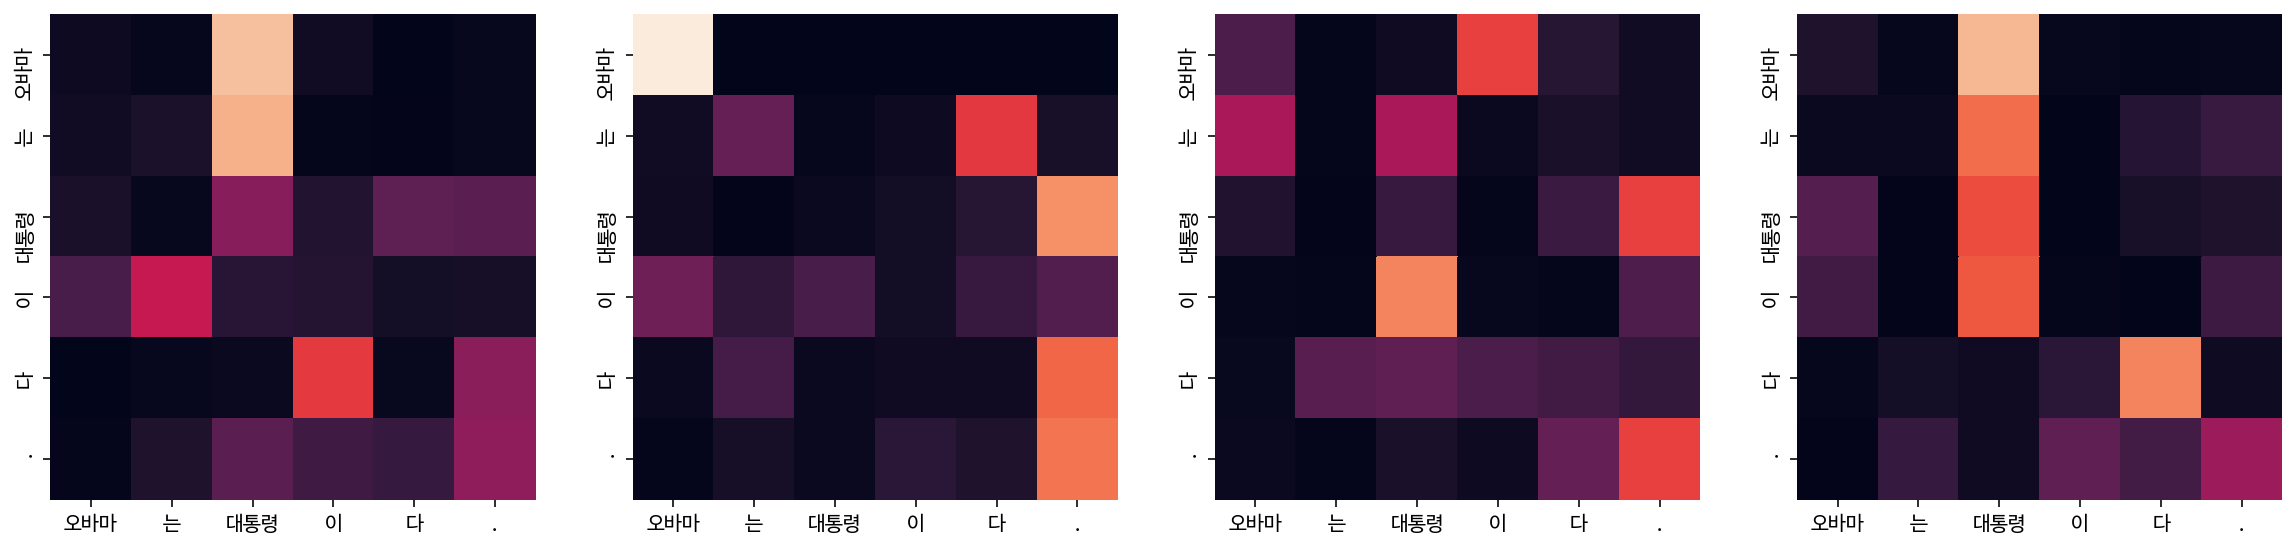



================================< Encoder Layer(=Self Attention) 2 >================================


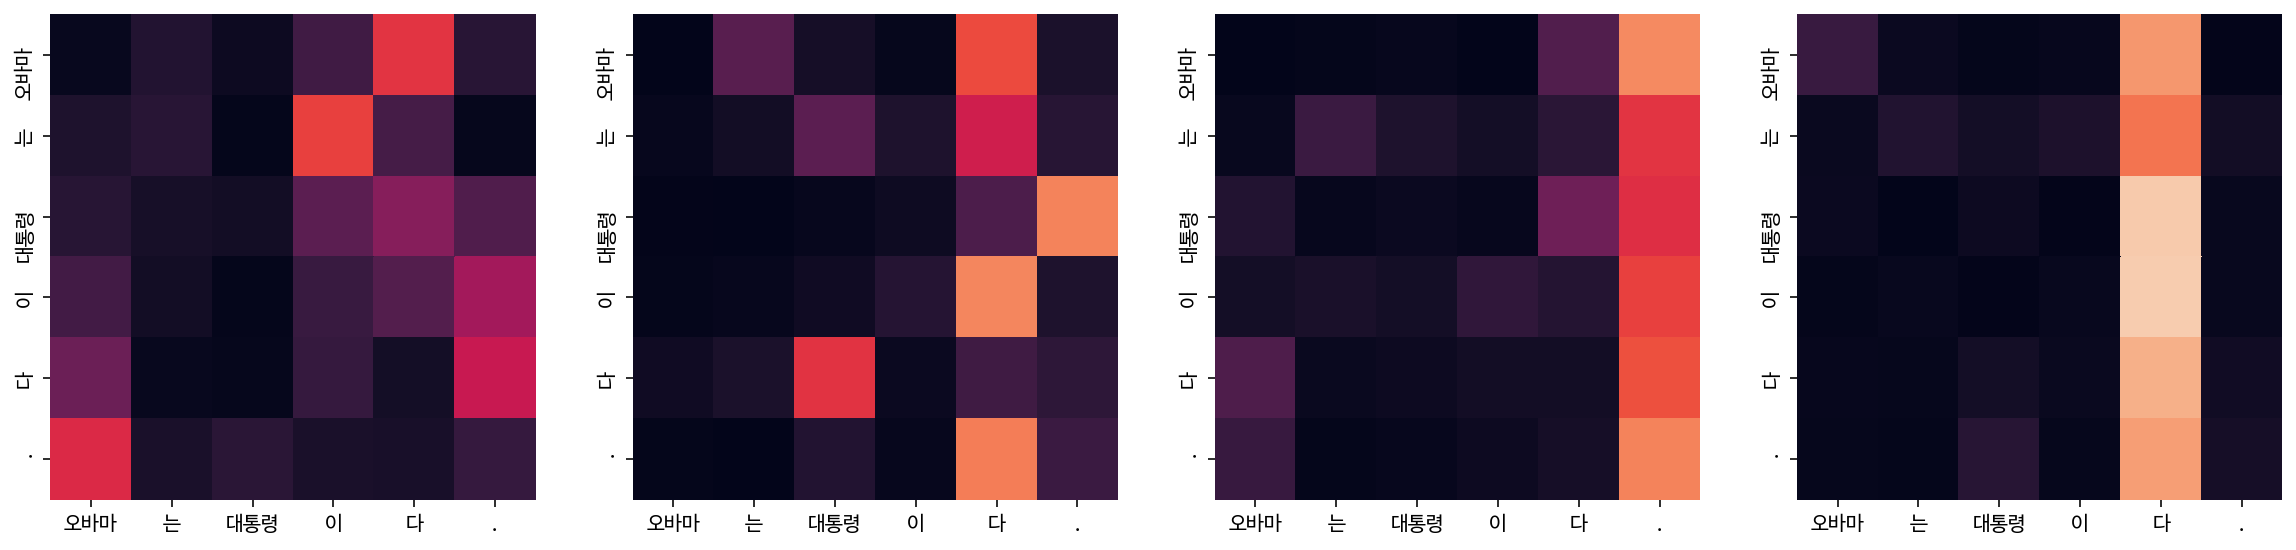



======================================< Decoder Self Layer 1 >======================================


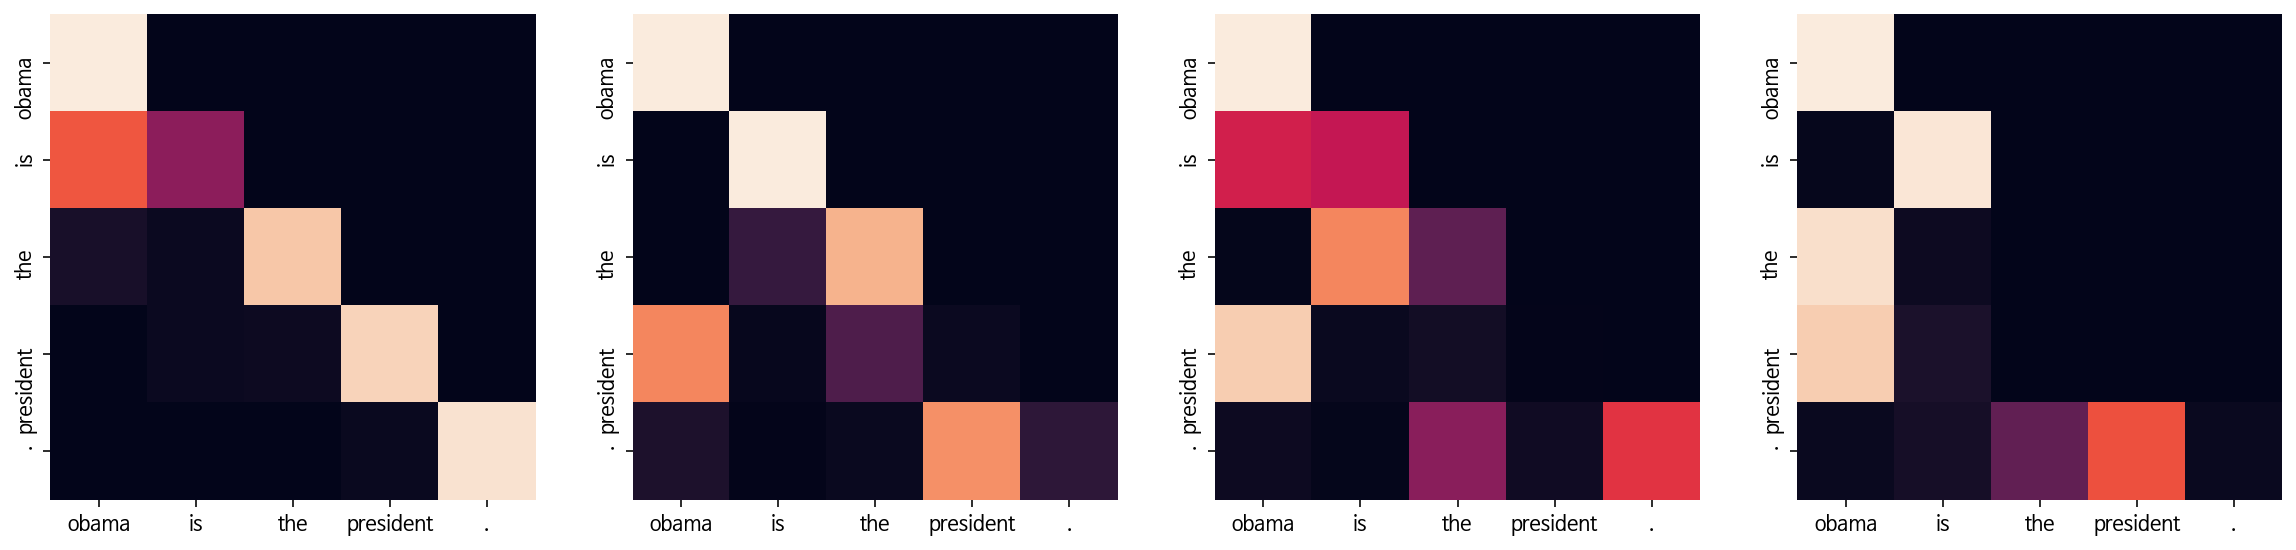



========================< Decoder Layer(Context Vector By Decoder Input) 1 >========================


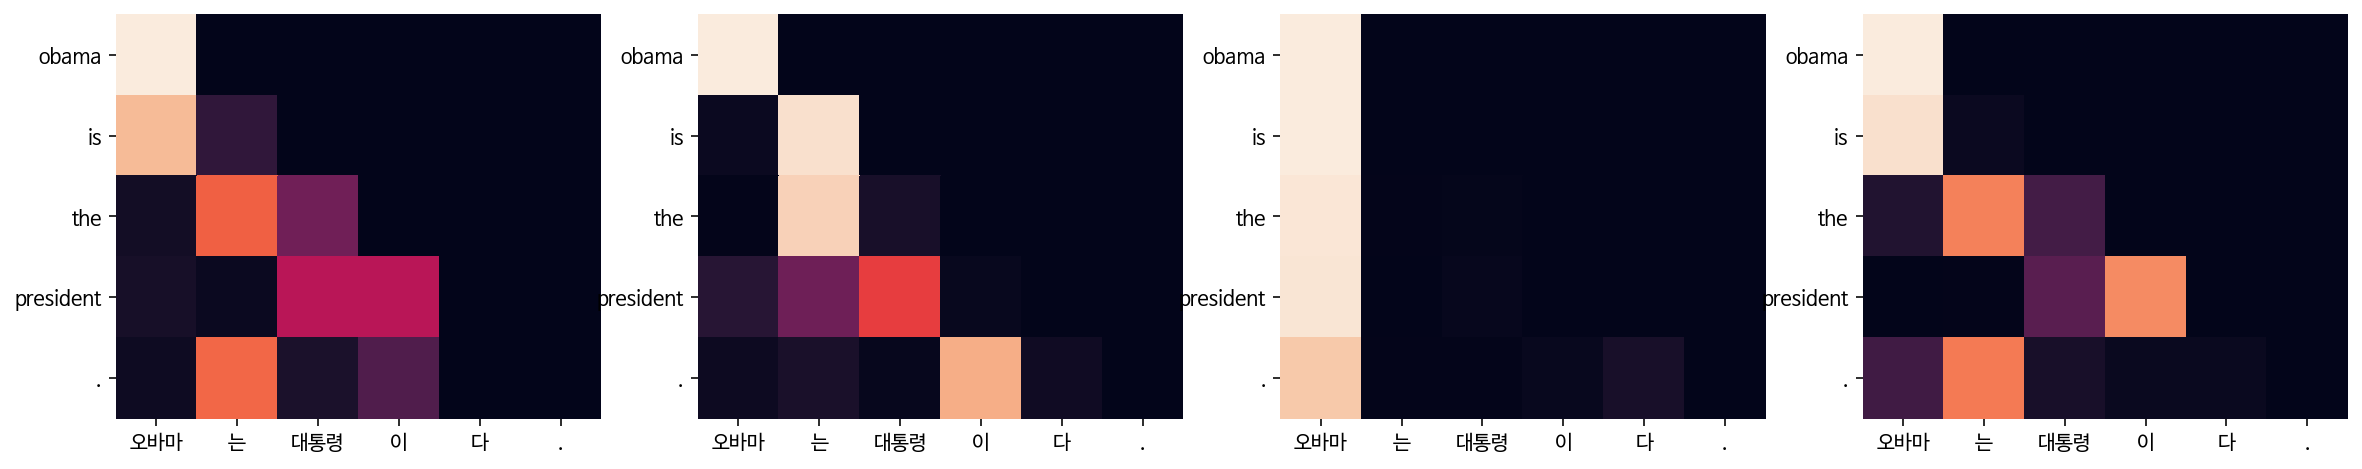



======================================< Decoder Self Layer 2 >======================================


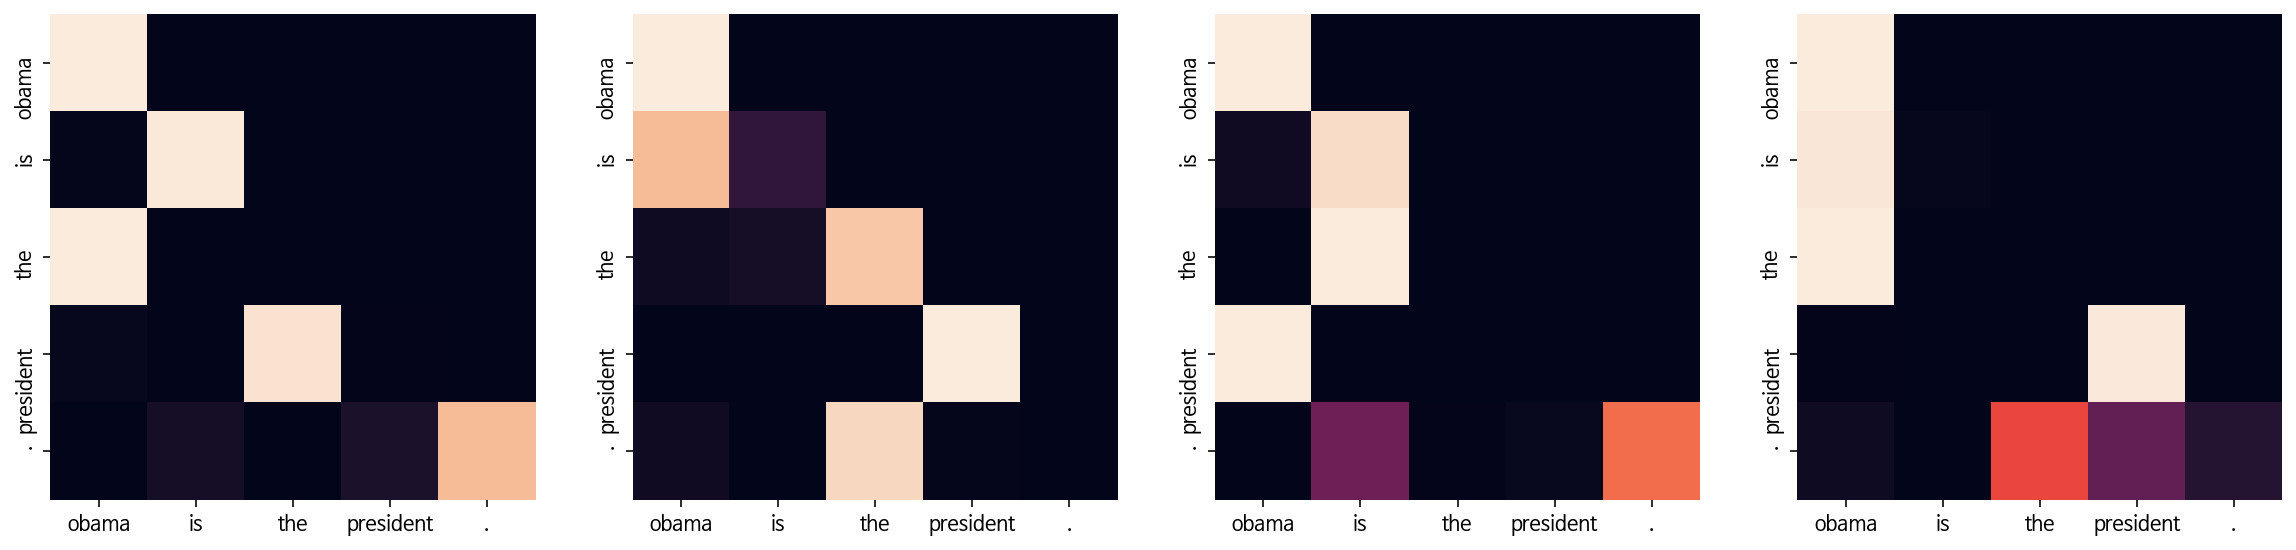



========================< Decoder Layer(Context Vector By Decoder Input) 2 >========================


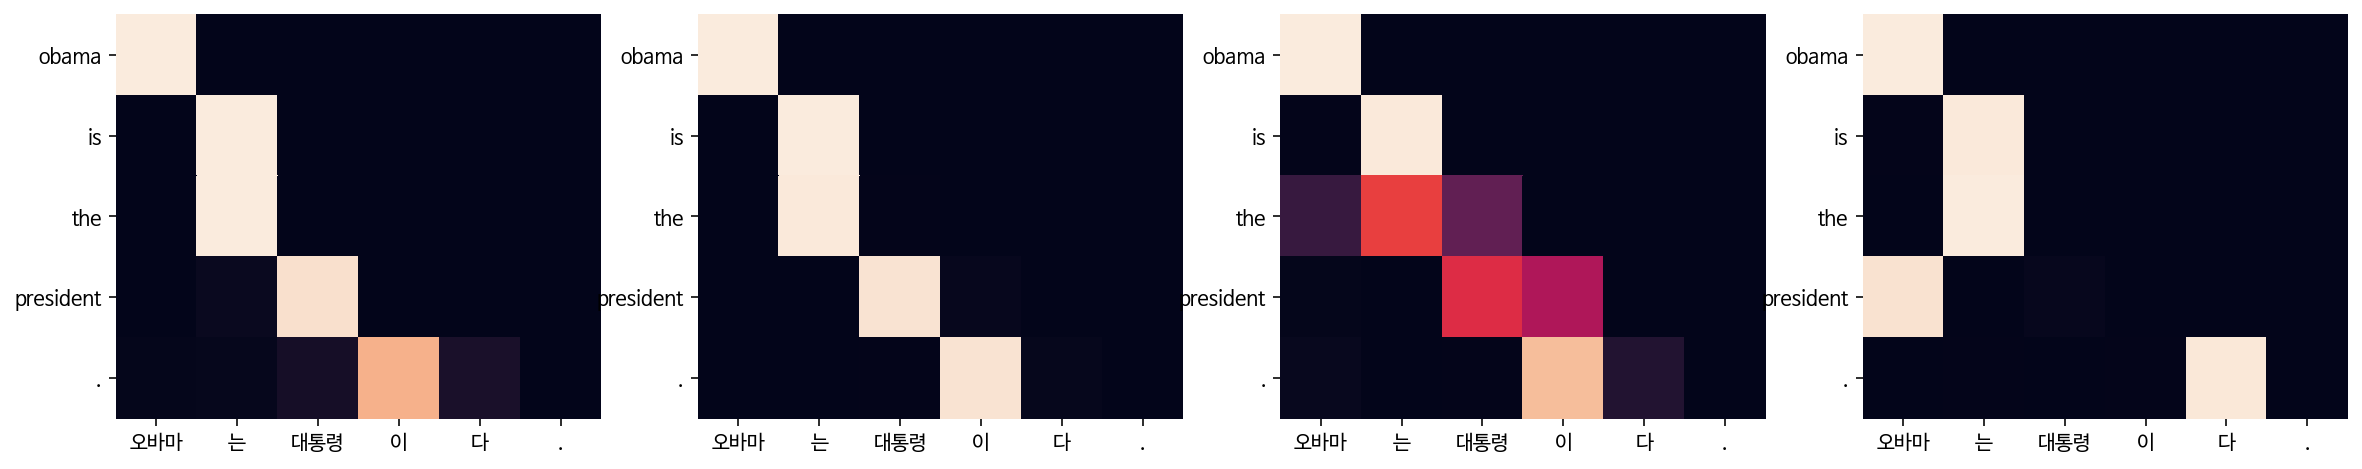

In [27]:
transformer = Transformer(
    n_layers=2,
    d_model=256,
    n_heads=8,
    d_ff=128,
    dropout=0.2,
    pos_len=200,
    shared=True,
    src_vocab_size=42516, tgt_vocab_size=37506
)

fit(mecab_enc_tensor, mecab_dec_tensor,mecab_enc_tokenizer, mecab_dec_tokenizer, tokenizer_type=True)   #mecab

<br>

### 7.2. SentencePiece 기반 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; SentencePiece는 문자의 빈도에 따라 토큰화를 진행하여 다양한 언어를 적용할 수 있다는 점과 OOV 문제를 해소할 수 있다는 장점이 있습니다. 따라서, 한국어와 영어 모두 SentencePiece를 이용하여 토큰화를 진행 하였습니다. 한국어의 단어사전 크기는 32,000개 이고 영어의 경우 24938개 입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 8개의 한국어 문장을 입력하여 모델이 출력한 번역 문장을 확인한 결과, '오바마는 대통령이다.' 한국어 문장을 'obama is the president.'로 올바르게 번역하였습니다. 그러나, 'seven seven seven deaths seven deaths.', 'i was a cat to be cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat.'과 같이 동일한 단어를 반복하고 번역이 올바르게 번역되지 않은 경우가 'Mecab'을 이용한 경우보다 잦습니다. 이러한 현상은 학습 초기에 발생하며, 학습이 지속될 수록 개선 됩니다. 본 예제에서는 Mecab과 SentencePiece의 공정한 비교를 위해 학습 회수를 동일하게 설정 하였습니다. 실제 한국어에 대해서는 Mecab이 SentencePiece에 비해 성능이 좋은 경우가 많습니다. 그럼에도 불구하고 SentencePiece가 주로 사용되는 이유는 대부분의 언어에 적용되는 토크나이저로 BaseLine과 같이 사용되기 때문 입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 인코더와 디코더의 셀프 어텐션과 인코더-디코더 어텐션을 시각화 하였습니다. 인코더-디코더 어텐션 시각화 결과를 확인하였을 때, '오바마'와 'obama' 그리고 '오바마'와 'president'의 연관도가 높음을 알 수 있습니다. SentencePiece 모델 또한, Transformer 모델이 'obama'가 'president'인 것을 올바르게 학습한 것이라 할 수 있습니다.
</span>

***

#### 모델 생성 및 학습
***
+ SentencePiece 데이터를 학습할 모델을 생성하고 학습 합니다.


+ 인코더 단어사전의 크기는 32,000이며, 디코더 단어사전의 크기는 24,938으로 설정 합니다.
***

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

============================================< EPOCH 4 >=============================================
  Korean Sentence: 오바마는 대통령이다.
 English Sentence: obama is very president .

  Korean Sentence: 시민들은 도시 속에 산다.
 English Sentence: relatives of the city s largest city .

  Korean Sentence: 커피는 필요 없다.
 English Sentence: coffee needed to be free .

  Korean Sentence: 일곱 명의 사망자가 발생했다.
 English Sentence: seven seven seven seven seven seven people were killed .

  Korean Sentence: 나는 고양이다.
 English Sentence: i don t enjoy my cat .

  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: dad s room is being a room .

  Korean Sentence: 아버지 가방에 들어가신다.
 English Sentence: father , the father of daddy .

  Korean Sentence: 오늘은 크리스마스다.
 English Sentence: christmas . christmas .





  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

  0%|          | 0/1207 [00:00<?, ?it/s]

============================================< EPOCH 9 >=============================================
  Korean Sentence: 오바마는 대통령이다.
 English Sentence: obama is the president .

  Korean Sentence: 시민들은 도시 속에 산다.
 English Sentence: they re in the city of small town .

  Korean Sentence: 커피는 필요 없다.
 English Sentence: no need for a perfect .

  Korean Sentence: 일곱 명의 사망자가 발생했다.
 English Sentence: seven seven seven deaths seven deaths

  Korean Sentence: 나는 고양이다.
 English Sentence: i was a cat to be cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat .

  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: as father , mouth is a room .

  Korean Sentence: 아버지 가방에 들어가신다.
 English Sentence: the boys , chased by friends .

  Korean Sentence: 오늘은 크리스마스다.
 English Sentence: day is today .



================================< Encoder Layer(=Self Attention) 1 >================================


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


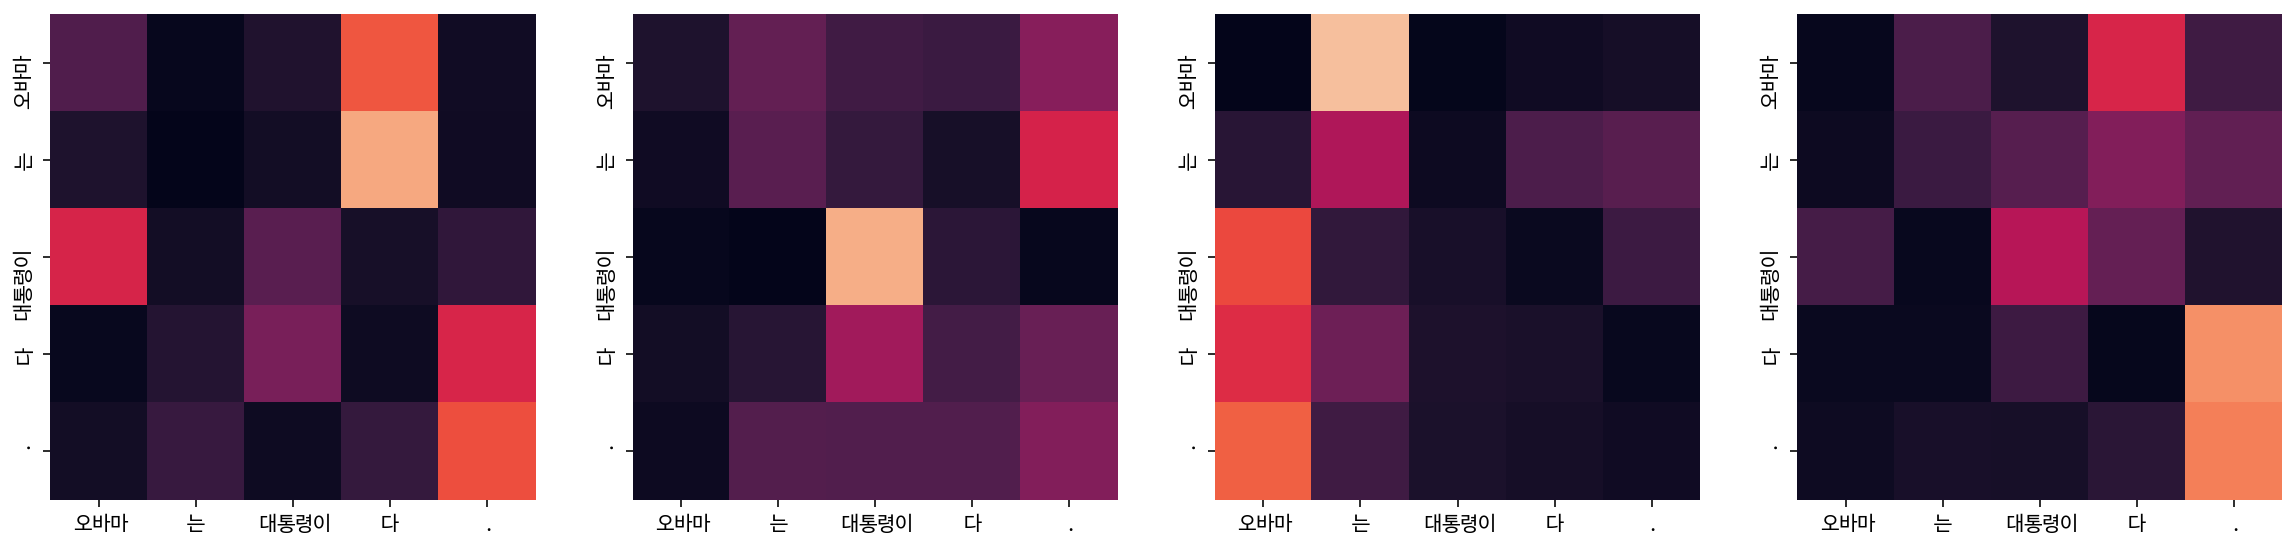



================================< Encoder Layer(=Self Attention) 2 >================================


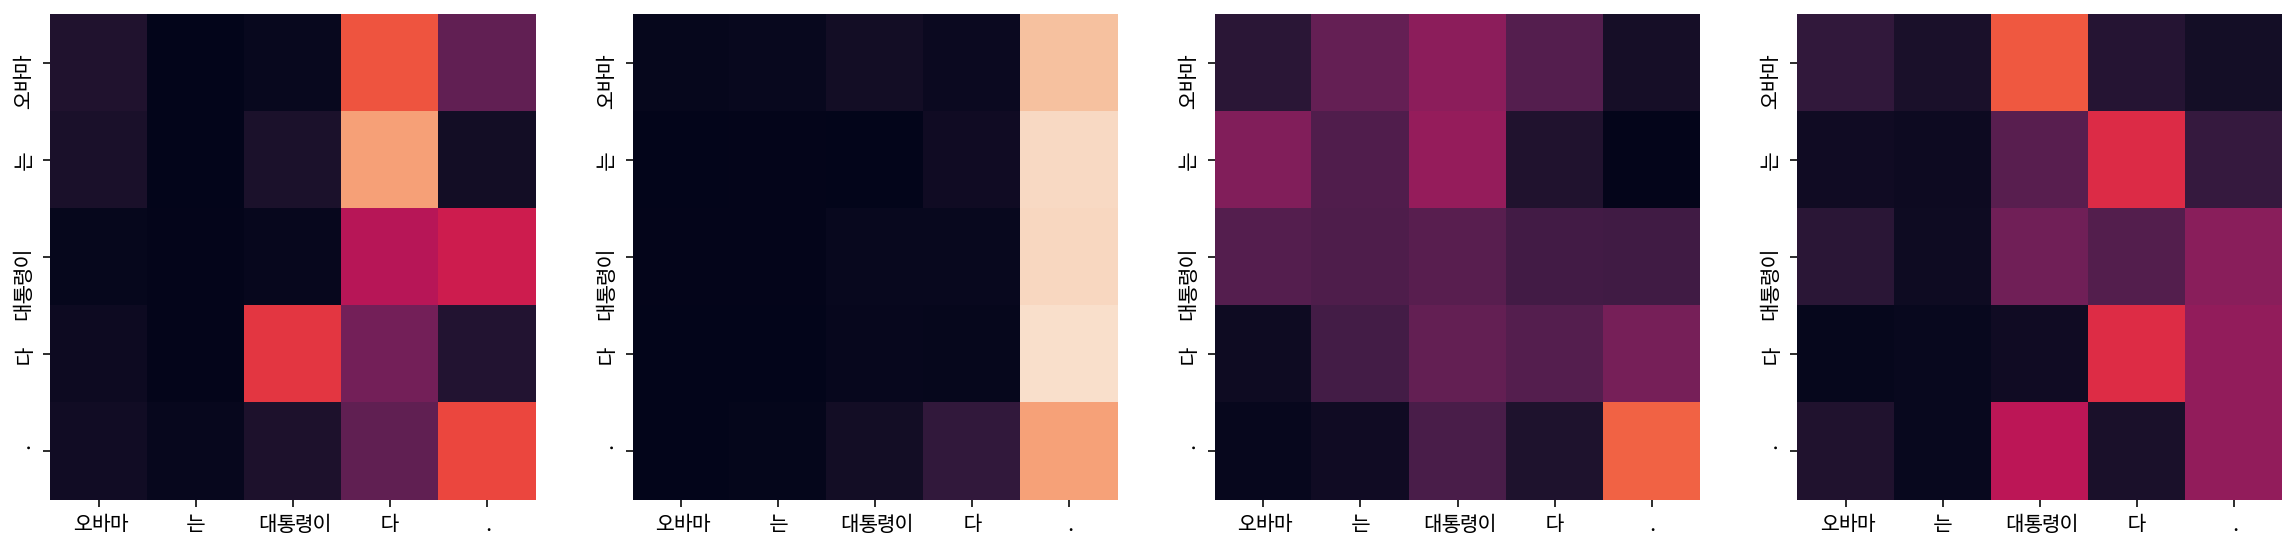



======================================< Decoder Self Layer 1 >======================================


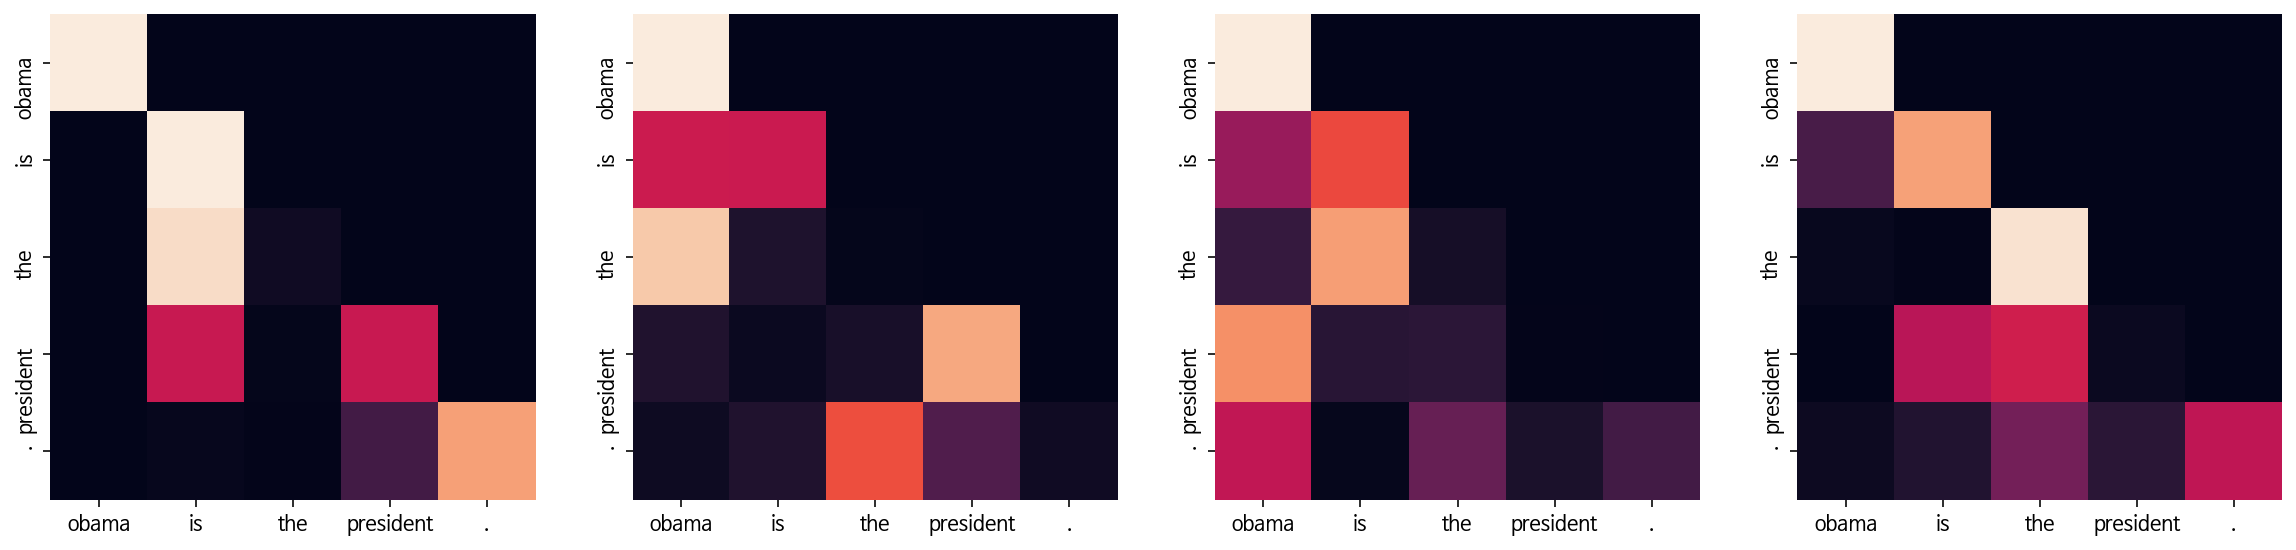



========================< Decoder Layer(Context Vector By Decoder Input) 1 >========================


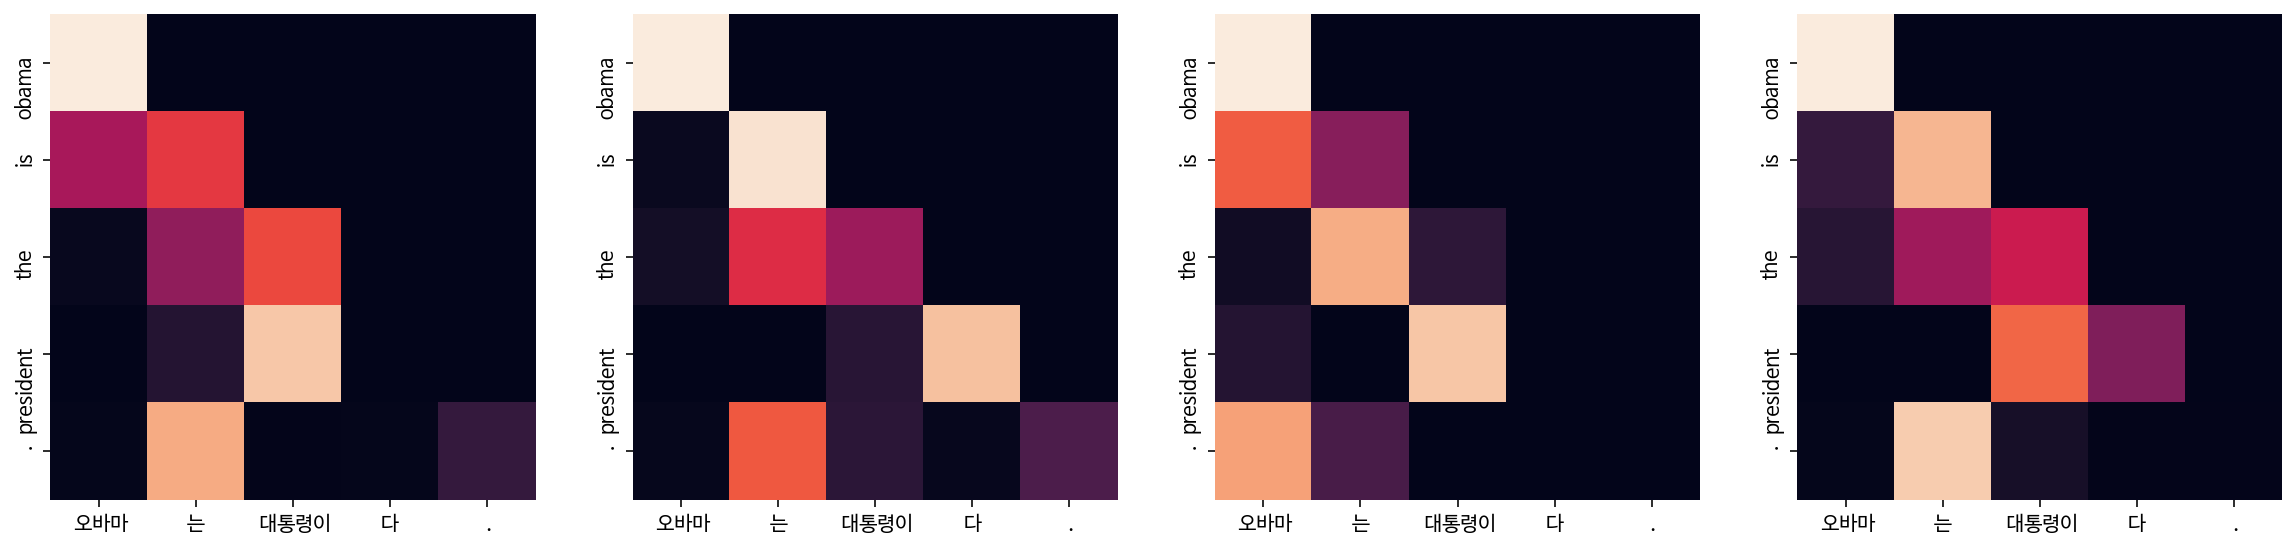



======================================< Decoder Self Layer 2 >======================================


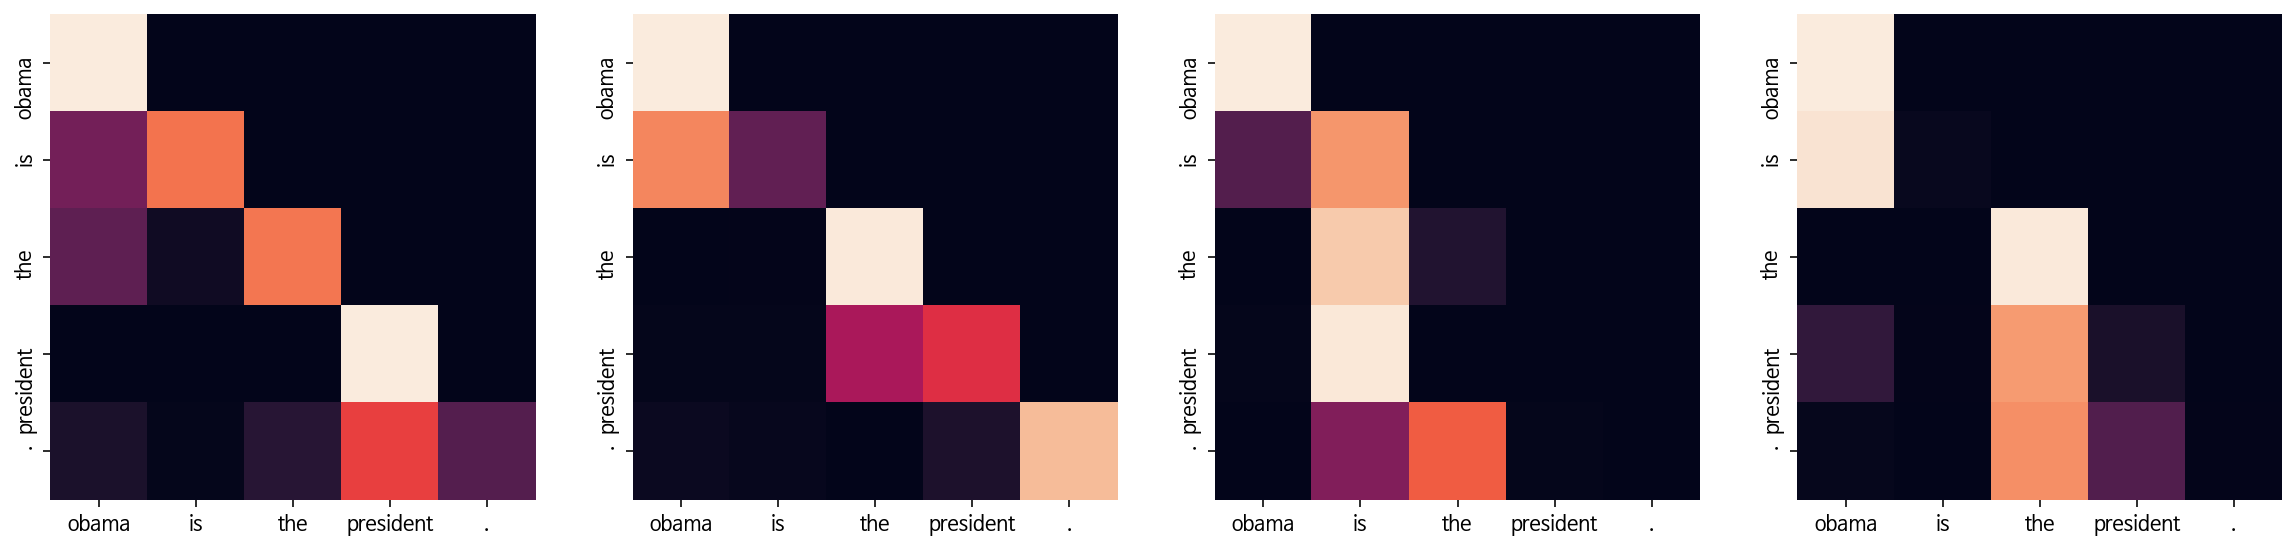



========================< Decoder Layer(Context Vector By Decoder Input) 2 >========================


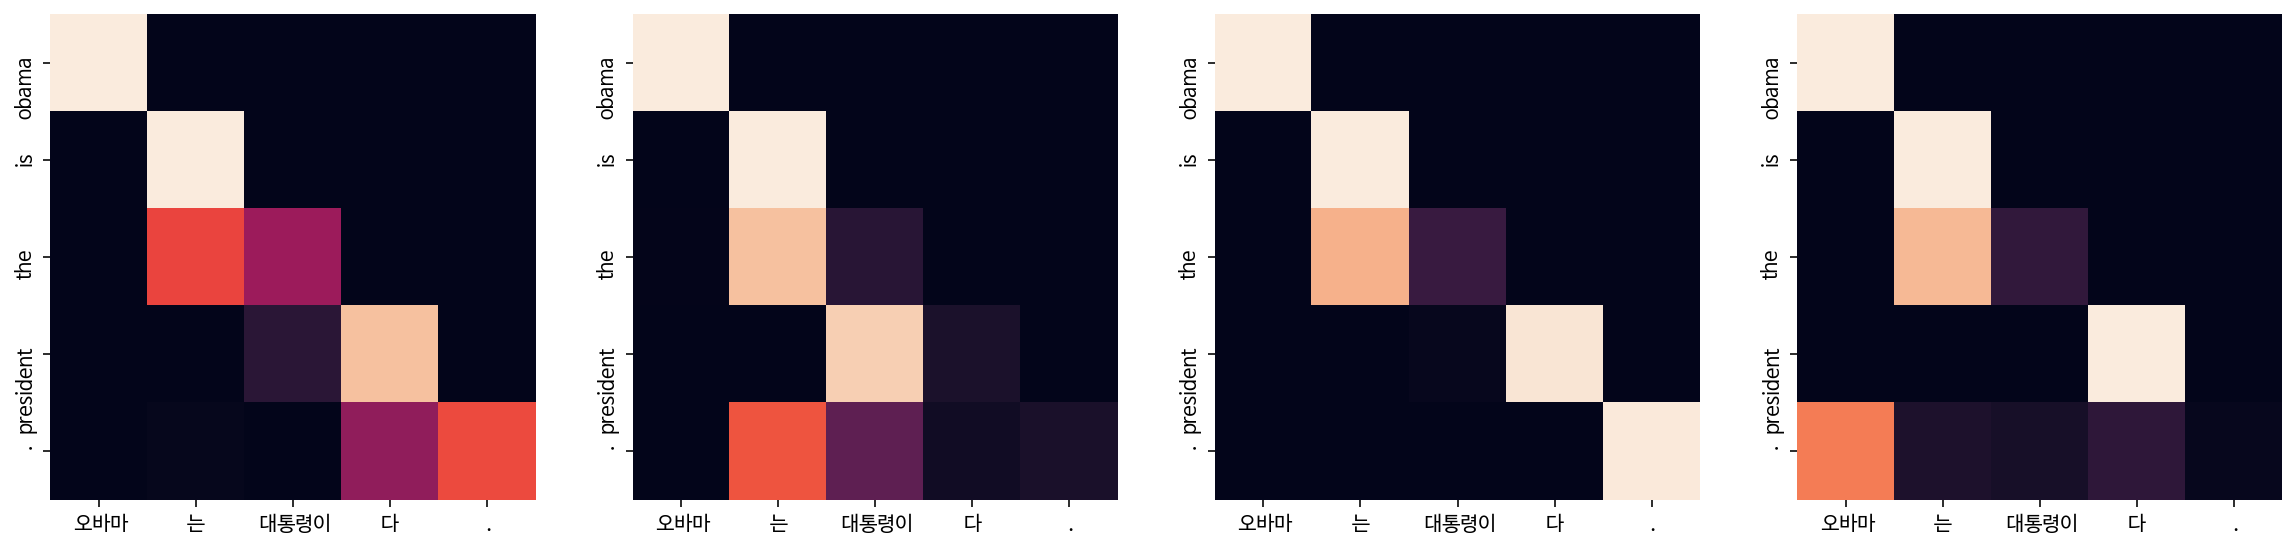

In [29]:
transformer = Transformer(
    n_layers=2,
    d_model=256,
    n_heads=8,
    d_ff=128,
    dropout=0.2,
    pos_len=200,
    shared=True,
    src_vocab_size=32000, tgt_vocab_size=24938
)

fit(sen_enc_tensor, sen_dec_tensor,sen_enc_tokenizer, sen_dec_tokenizer, tokenizer_type=False)   #SentencePiece

<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 Transformer를 이용하여 한국어-영어 번역 모델을 생성, 학습하였습니다. 이전 going_deeper 08의 Bahadanau Attention의 번역 결과 그리고 Mecab과 SentencePiece에 따른 번역 결과를 비교 하고자 합니다. 총 세 개의 모델로, 'Bahadanau Attention 모델'과 'Mecab을 이용한 Transformer 모델', 'SentencePiece를 이용한 Transformer 모델'의 번역 결과를 확인 합니다. 세 모델 모두 임베딩 사이즈를 동일하게 적용하였으며, Transformer 모델의 경우, 인코딩 및 디코딩 레이어를 두 층으로 설정하고 피드 포워드 레이어의 유닛 수를 128개로 하여 Bahadanau Attention과 학습 시간을 비슷하게 맞추어 모델 간의 크기를 동일하게 설정하고자 하였습니다. [표 4]는 모델별 하이퍼파라미터를 제시한 것입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 세 모델의 번역 결과를 확인 하였습니다. '오바마는 대통령이다.'라는 문장을 입력하였을 때, Bahdanau Attention의 경우 'obama is a member of us.'로 올바르지 않게 번역이 이루어졌습니다. Transformer의 경우 'obama is the president.'로 번역이 올바르게 이루어졌습니다. 또한, Mecab의 경우 '나는 고양이다.' 문장을 'I'm cat.'으로 비교적 올바르게 번역 하였습니다. 반대로 '일곱 명의 사망자가 발생했다.'의 문장의 경우에는 Transformer에서 'seven of the seven deaths.'와 'seven seven seven deaths seven deaths'로 번역 되어, Bahdanau Attention의 'seven people were killed.'가 비교적 잘 번역된 것이라 할 수 있습니다. '오바마는 대통령이다.' 문장에 대한 각 모델의 Attention을 시각화 하였을 때, Bahdanau Attention의 경우 '오바마'와 'president'의 연관성이 높지 않게 출력되었습니다. 하지만 Transformer의 경우에는 Mecab과 SentencePiece 모두 연관성이 높게 출력되어 모델이 이를 잘 학습 되어진 것을 확인할 수 있었습니다. [표 5]는 모델별 한국어-영어 번역 결과를 제시한 것입니다.
</span><br><br>

|Model|Embedding size|Epochs|Epoch /sec|
|:--------:|:--------:|:--------:|:--------:|
|**Bahdanau Attention(Base Line)**|256|20|약 10 minute|
|**Transformer(Mecab)**|256|10|약 10 minute|
|**Transformer(SentencePiece)**|256|10|약 10 minute|

[표 4] 모델별 하이퍼파라미터 및 학습 속도

<br><br>

|한국어 문장|Bahdanau Attention(Base Line)|Transformer(Mecab)|Transformer(SentencePiece)|
|:--------:|:--------:|:--------:|:--------:|
|오바마는 대통령이다.|obama is a member of us.|obama is the president.|obama is the president.|
|시민들은 도시 속에 산다.|the city of the city of the city.|citizens are generally much in cities.|they're in the city of small town.|
|커피는 필요 없다.|the coffee is to be|why don't take advantage of the coffee.|no need for a perfect.|
|일곱 명의 사망자가 발생했다.|seven people were killed.|seven of the seven deaths.|seven seven seven deaths seven deaths|
|나는 고양이다.|i don t have a lot of the cat.|i'm cat.|i was a cat to be cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat cat.|
|아버지가 방에 들어가신다.|the father was a.|father and brother husband, like he was taken to a room.|as father, mouth is a room.|
|아버지 가방에 들어가신다.|the boy s father s|then bag contained bag bag , and bag.|the boys, chased by friends.|
|오늘은 크리스마스다.|today is a day|today's christmas is today.|day is today.|

[표 5] 모델별 한국어-영어 번역 결과

***

#### 형상관리 기록
***
+ v1_1: 실습 예제 진행


+ v1_2: 제출 예제 진행


+ v2_1: Mecab 및 SentencePiece 도입(d_model=256, d_ff=256, epoch=15)


+ v3_1: transformer 하이퍼파라미터 변경(d_model=256, d_ff=256, epoch=20)


+ v4_1: transformer 하이퍼파라미터 변경(d_model=256, d_ff=128, epoch=10)
***